<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw1/hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you load this notebook by clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement autoregressive models and run it on various datasets. Oftentime you will run it on two datasets (dataset 1 and dataset 2). In these cases, the expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the images outputted in the results/ folder and upload them to the figure folder in the given latex template.

There is a lot of freedom in this homework to design write and design your own models. Hyperparameters are given as a guide to show what worked for us, but feel free to explore and use what you find is best!

Run the cells below to download and load up the starter code.

In [1]:
# !if [ -d deepul ]; then rm -Rf deepul; fi
# !git clone https://github.com/rll/deepul.git
# !unzip -qq deepul/homeworks/hw1/data/hw1_data.zip -d deepul/homeworks/hw1/data/
# !pip install ./deepul

# Imports

In [1]:
import itertools
import os
import time

from torch.utils import data
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np

import deepul.utils as deepul_utils
from deepul import hw1_helper
from deepul.hw1_helper import (
    # Q1
    visualize_q1_data,
    q1_sample_data_1,
    q1_sample_data_2,
    q1_save_results,
    # Q2
    q2a_save_results,
    q2b_save_results,
    visualize_q2a_data,
    visualize_q2b_data,
    # Q3
    q3ab_save_results,
    q3c_save_results,
    # Q4
    q4a_save_results,
    q4b_save_results,
    # Q5
    visualize_q5_data,
    q5a_save_results,
    # Q6
    visualize_q6_data,
    q6a_save_results,
)

In [2]:
# os.chdir("/nas/ucb/ebronstein/deepul/deepul/homeworks/hw1")

# Question 1: 1D Data

In this question, we will train simple generative models on discrete 1D data.

Execute the cell below to visualize our datasets

Dataset 1


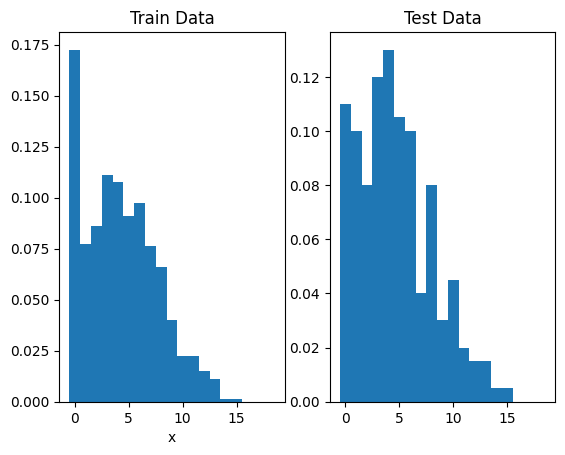

Dataset 2


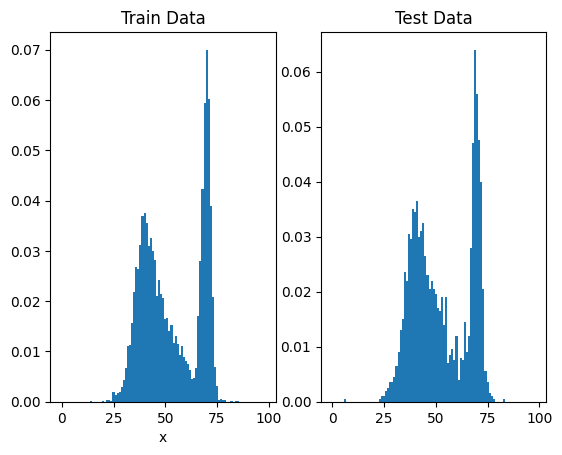

In [2]:
visualize_q1_data(dset_type=1)
visualize_q1_data(dset_type=2)

## Part (a) Fitting a Histogram

Let $\theta = (\theta_0, \dots, \theta_{99}) \in \mathbb{R}^{100}$ and define the model $p_\theta(x) = \frac{e^{\theta_x}}{\sum_{x'}e^{\theta_{x'}}}$

Fit $p_\theta$ with maximum likelihood via stochastic gradient descent on the training set, using $\theta$ initialized to zero. Use your favorite version of stochastic gradient descent, and optimize your hyperparameters on a validation set of your choice.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Plot the model probabilities in a bar graph with $\{0,\dots,99\}$ on the x-axis and a real number in $[0,1]$ on the y-axis.




Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [42]:
class Histogram(nn.Module):
    def __init__(self, d=30):
        super().__init__()
        self.d = d
        self.logits = nn.Parameter(torch.zeros(d))

    def loss(self, x):
        # Shape: [batch_size, d]
        logits = self.logits.unsqueeze(0).repeat(x.shape[0], 1)
        return F.cross_entropy(logits, x.long())

    def probabilities(self):
        return F.softmax(self.logits, dim=-1)

In [43]:
def eval(model, dataloader, device="cuda"):
    model = model.to(device)
    model.eval()

    total_loss = 0
    for batch in dataloader:
        batch = batch.to(device)
        loss = model.loss(batch)
        total_loss += loss.item() * batch.shape[0]

    return total_loss / len(dataloader.dataset)


def train(
    model,
    train_dataloader,
    test_dataloader,
    epochs,
    learning_rate,
    device="cuda",
    verbose=False,
):
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_losses = []
    test_losses = []
    test_losses.append(eval(model, test_dataloader, device))

    for epoch in range(epochs):
        model.train()
        epoch_losses = []
        for batch in train_dataloader:
            batch = batch.to(device)
            optimizer.zero_grad()
            loss = model.loss(batch)
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        train_losses.extend(epoch_losses)
        test_losses.append(eval(model, test_dataloader, device))

        if (epoch + 1) % 10 == 0 and verbose:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item()}")

    return train_losses, test_losses


def sweep(model, get_data_fn, epochs_list, lrs, batch_sizes, verbose=False):
    hparams_to_loss = {}

    train_data, test_data = get_data_fn()

    for lr, batch_size, epochs in itertools.product(lrs, batch_sizes, epochs_list):
        print(f"Training with lr={lr}, batch_size={batch_size}, epochs={epochs}")

        train_dataloader = data.DataLoader(
            train_data, batch_size=batch_size, shuffle=True
        )
        test_dataloader = data.DataLoader(
            test_data, batch_size=batch_size, shuffle=True
        )

        train_losses, test_losses = train(
            model, train_dataloader, test_dataloader, epochs, lr, verbose=verbose
        )
        last_train_loss = train_losses[-1]
        last_test_loss = test_losses[-1]
        hparams_to_loss[(lr, batch_size, epochs)] = (last_train_loss, last_test_loss)

    return hparams_to_loss

In [106]:
dset_id = 1

if dset_id == 1:
    get_data_fn = q1_sample_data_1
elif dset_id == 2:
    get_data_fn = q1_sample_data_2
else:
    raise ValueError("dset_id must be 1 or 2")

d = 100  # For example, 10 bins

# lrs = [0.1, 0.01, 0.001]
# batch_sizes = [32, 64, 128]
# epochs_list = [10, 20, 100]
lrs = [0.1]
batch_sizes = [64]
epochs_list = [20]

verbose = False

model = Histogram(d)
hparams_to_loss = sweep(model, get_data_fn, epochs_list, lrs, batch_sizes, verbose)

Training with lr=0.1, batch_size=64, epochs=20


In [107]:
min(hparams_to_loss, key=lambda x: hparams_to_loss[x][1])

(0.1, 64, 20)

In [5]:
def q1_a(train_data, test_data, d, dset_id):
    """
    train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
    test_data: An (n_test,) numpy array of integers in {0, .., d-1}
    d: The number of possible discrete values for random variable x
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (d,) of model probabilities
    """
    if dset_id == 1:
        learning_rate = 0.1
        batch_size = 64
        epochs = 100
    elif dset_id == 2:
        learning_rate = 0.1
        batch_size = 128
        epochs = 20

    verbose = False

    train_dataloader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_dataloader = data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

    model = Histogram(d)

    train_losses, test_losses = train(
        model, train_dataloader, test_dataloader, epochs, learning_rate, verbose=verbose
    )
    distribution = model.probabilities().detach().cpu().numpy()

    return train_losses, test_losses, distribution

### Results

Once you've implemented `q1_a`, execute the cells below to visualize and save your results



Final Test Loss: 2.5365


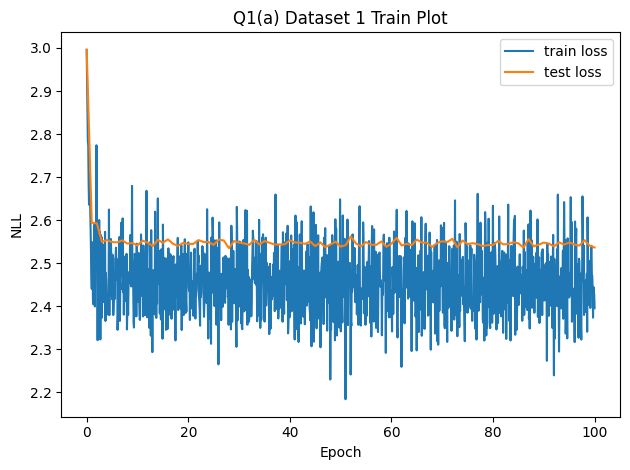

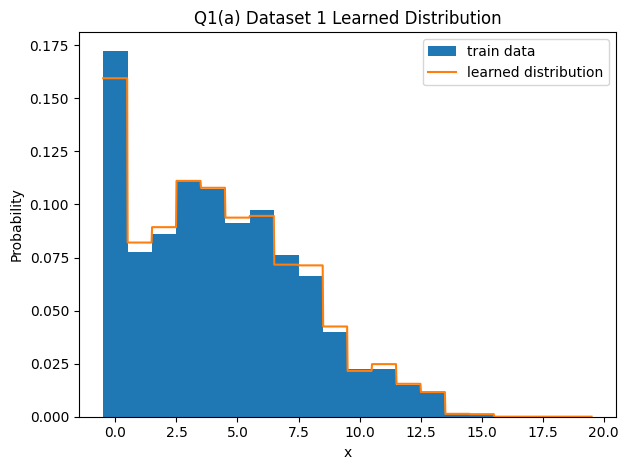

In [6]:
q1_save_results(1, "a", q1_a)

Final Test Loss: 3.6712


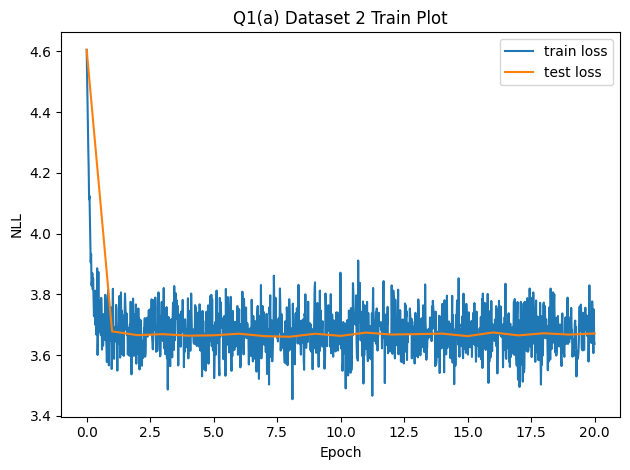

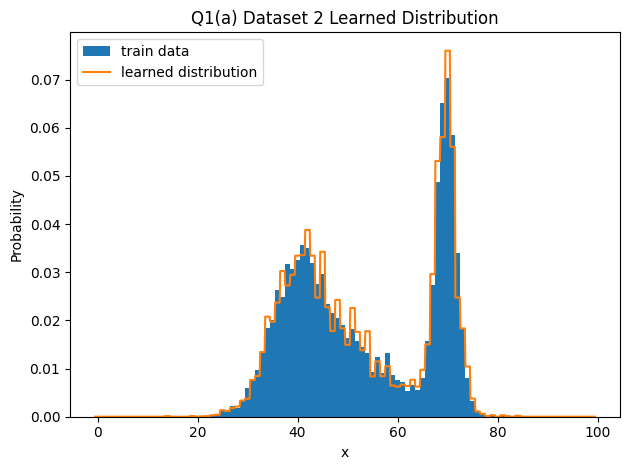

In [7]:
q1_save_results(2, "a", q1_a)

## Part (b) Fitting Discretized Mixture of Logistics

Let us model $p_\theta(x)$ as a **discretized** mixture of 4 logistics such that $p_\theta(x) = \sum_{i=1}^4 \pi_i[\sigma((x+0.5 - \mu_i)/s_i) - \sigma((x-0.5-\mu_i)/s_i)]$

For the edge case of when $x = 0$, we replace $x-0.5$ by $-\infty$, and for $x = 99$, we replace $x+0.5$ by $\infty$.

You may find the [PixelCNN++](https://arxiv.org/abs/1701.05517) helpful for more information on discretized mixture of logistics.

**Provide the same set of corresponding deliverables as part (a)**

Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [58]:
class MixtureOfLogistics(nn.Module):
    def __init__(self, d, num_mix=4):
        super().__init__()
        self.d = d
        self.num_mix = num_mix

        # pi_i
        self.logits = nn.Parameter(torch.zeros(num_mix))
        # mu_i
        self.means = nn.Parameter(
            torch.arange(num_mix, dtype=torch.float32) / (num_mix - 1) * d
        )
        # Log of scale s_i
        # self.log_scales = nn.Parameter(torch.randn(num_mix))
        self.log_scales = nn.Parameter(torch.zeros(num_mix))

        # Tolerance for log probability near 0 and d - 1.
        self._log_prob_tol = 1e-3
        # Min value for CDF for numerical stability when taking the log.
        self._cdf_min = 1e-12

    def forward(self, x):
        x = x.float()
        # [batch_size, num_mix]
        x = x.unsqueeze(1).repeat(1, self.num_mix)
        # [1, num_mix]
        means, log_scales = self.means.unsqueeze(0), self.log_scales.unsqueeze(0)
        log_scales = torch.clamp(log_scales, min=-10.0)
        # 1 / s_i
        inv_scales = torch.exp(-log_scales)

        # CDF of logistics at x + 0.5
        sigmoid_top = torch.sigmoid(inv_scales * (x + 0.5 - means))
        # CDF of logistics at x - 0.5
        sigmoid_bottom = torch.sigmoid(inv_scales * (x - 0.5 - means))
        cdf_delta = sigmoid_top - sigmoid_bottom
        # Log CDF
        log_cdf_delta = torch.log(torch.clamp(cdf_delta, min=self._cdf_min))

        # Log CDF for x = 0
        log_cdf_max = torch.log(
            torch.clamp(torch.sigmoid(inv_scales * (0.5 - means)), min=self._cdf_min)
        )
        # Log CDF for x = d - 1 = 99
        log_cdf_min = torch.log(
            torch.clamp(
                1 - torch.sigmoid(inv_scales * (self.d - 1 - 0.5 - means)),
                min=self._cdf_min,
            )
        )
        # Replace x = d - 1 with log CDF for x = d - 1
        x_log_probs = torch.where(
            x > self.d - 1 - self._log_prob_tol, log_cdf_min, log_cdf_delta
        )
        # Replace x = 0 with log CDF for x = 0
        x_log_probs = torch.where(x < self._log_prob_tol, log_cdf_max, x_log_probs)
        pi_log_probs = F.log_softmax(self.logits, dim=0).unsqueeze(0)
        log_probs = x_log_probs + pi_log_probs
        return torch.logsumexp(log_probs, dim=1)

    def loss(self, x):
        # The forward pass on x returns log probabilities, so we take the mean
        # and negate it to get negative log likelihood loss.
        return -torch.mean(self(x))

    def probabilities(self):
        with torch.no_grad():
            bins = torch.arange(self.d, dtype=torch.float32, device=self.logits.device)
            return torch.exp(self(bins))

In [45]:
# class DiscretizedLogisticMixtureModel(nn.Module):
#     def __init__(self, num_mixtures=4, num_inputs=3):
#         super(DiscretizedLogisticMixtureModel, self).__init__()
#         # Simple linear layer to output the parameters for the mixture model
#         self.fc = nn.Linear(num_inputs, num_mixtures * 3)

#     # TODO: combine with loss function, just make the loss function take the mean.
#     def forward(self, x):
#         params = self.fc(x)
#         pi, mu, s = torch.chunk(params, 3, dim=-1)
#         pi = F.softmax(pi, dim=-1)  # Mixture coefficients
#         mu = torch.tanh(mu)         # Means
#         s = F.softplus(s)           # Scales
#         return pi, mu, s

#     # TODO: make instance method.
#     def discretized_logistic_loss(self, x, pi, mu, s):
#         # Handle edge cases for x = 0 and x = 99
#         x_plus = x + 0.5
#         x_minus = x - 0.5
#         x_plus[x_plus > 99] = float('inf')
#         x_minus[x_minus < 0] = float('-inf')

#         # Logistic function
#         sigmoid_plus = torch.sigmoid((x_plus - mu) / s)
#         sigmoid_minus = torch.sigmoid((x_minus - mu) / s)

#         # Discretized logistic likelihood
#         cdf_delta = sigmoid_plus - sigmoid_minus
#         cdf_delta = torch.clamp(cdf_delta, min=1e-12)  # Avoid log(0)

#         # Negative log likelihood
#         log_prob = torch.log(cdf_delta)
#         log_mix = torch.log(pi) + log_prob
#         loss = -torch.logsumexp(log_mix, dim=-1)
#         return loss.mean()

#     # TODO: implement
#     def distribution(model, num_samples=1):
#         with torch.no_grad():
#             model.eval()
#             # Sample from the model (this part will depend on your model's input)
#             samples = torch.randn(num_samples, 3)  # Replace with appropriate input
#             pi, mu, s = model(samples)
#             # Sampling logic here (omitted for brevity)
#             # ...
#             return samples


# # def train(model, data_loader, optimizer, epochs=10):
# #     model.train()
# #     for epoch in range(epochs):
# #         total_loss = 0
# #         for x in data_loader:
# #             optimizer.zero_grad()
# #             pi, mu, s = model(x)
# #             loss = discretized_logistic_loss(x, pi, mu, s)
# #             loss.backward()
# #             optimizer.step()
# #             total_loss += loss.item()
# #         print(f"Epoch {epoch}, Loss: {total_loss / len(data_loader)}")

In [46]:
# get_data_fn = q1_sample_data_1

# model = MixtureOfLogistics(d, n_mix=4).cuda()
# dset_id = 1
# epochs_list = [10, 20]
# lrs = [0.1, 0.01, 0.001]
# batch_sizes = [32, 64, 128]
# hparams_to_loss = sweep(model, get_data_fn, epochs_list, lrs, batch_sizes, verbose)

In [47]:
# min(hparams_to_loss, key=lambda x: hparams_to_loss[x][1])

In [81]:
def q1_b(train_data, test_data, d, dset_id):
    """
    train_data: An (n_train,) numpy array of integers in {0, ..., d-1}
    test_data: An (n_test,) numpy array of integers in {0, .., d-1}
    d: The number of possible discrete values for random variable x
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (d,) of model probabilities
    """
    # batch_size = 32
    # epochs = 20
    # lr = 0.01
    if dset_id == 1:
        batch_size = 256
        epochs = 40
        lr = 1e-1
    elif dset_id == 2:
        batch_size = 8000
        epochs = 1000
        lr = 1e-1

    model = MixtureOfLogistics(d, num_mix=4).cuda()
    train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=batch_size)
    train_losses, test_losses = train(
        model, train_loader, test_loader, epochs, lr, verbose=True
    )
    distribution = model.probabilities().detach().cpu().numpy()

    return train_losses, test_losses, distribution

### Results

Once you've implemented `q1_b`, execute the cells below to visualize and save your results



Epoch [10/40], Loss: 2.649141788482666
Epoch [20/40], Loss: 2.627520799636841
Epoch [30/40], Loss: 2.5062429904937744
Epoch [40/40], Loss: 2.5655620098114014
Final Test Loss: 2.5495


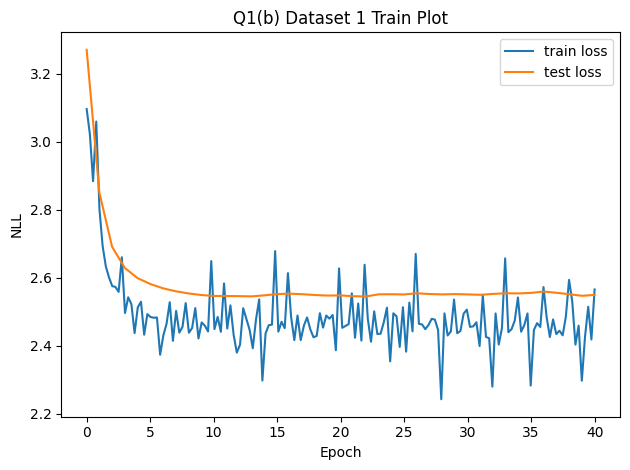

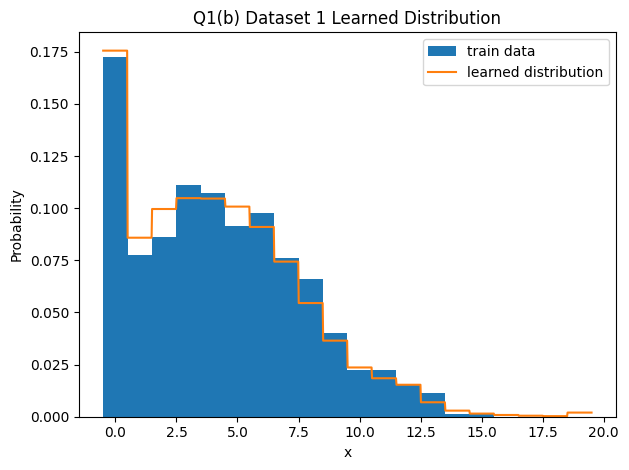

In [76]:
q1_save_results(1, "b", q1_b)

In [67]:
from deepul import hw1_helper

train_data, test_data = hw1_helper.q1_sample_data_2()
model = MixtureOfLogistics(100, num_mix=4)
train_loader = data.DataLoader(train_data, batch_size=16, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=16)

In [70]:
-model(torch.tensor(train_data)).mean()

tensor(8.1180, grad_fn=<NegBackward0>)

Epoch [10/1000], Loss: 4.673442840576172
Epoch [20/1000], Loss: 4.097015857696533
Epoch [30/1000], Loss: 4.073166847229004
Epoch [40/1000], Loss: 4.048735618591309
Epoch [50/1000], Loss: 4.00498104095459
Epoch [60/1000], Loss: 3.962636947631836
Epoch [70/1000], Loss: 3.9265694618225098
Epoch [80/1000], Loss: 3.8885438442230225
Epoch [90/1000], Loss: 3.8507323265075684
Epoch [100/1000], Loss: 3.8194596767425537
Epoch [110/1000], Loss: 3.796598434448242
Epoch [120/1000], Loss: 3.779618978500366
Epoch [130/1000], Loss: 3.7642335891723633
Epoch [140/1000], Loss: 3.7497446537017822
Epoch [150/1000], Loss: 3.736757516860962
Epoch [160/1000], Loss: 3.725510835647583
Epoch [170/1000], Loss: 3.7159810066223145
Epoch [180/1000], Loss: 3.708094358444214
Epoch [190/1000], Loss: 3.7017276287078857
Epoch [200/1000], Loss: 3.6967010498046875
Epoch [210/1000], Loss: 3.6928048133850098
Epoch [220/1000], Loss: 3.6898303031921387
Epoch [230/1000], Loss: 3.6875860691070557
Epoch [240/1000], Loss: 3.685907

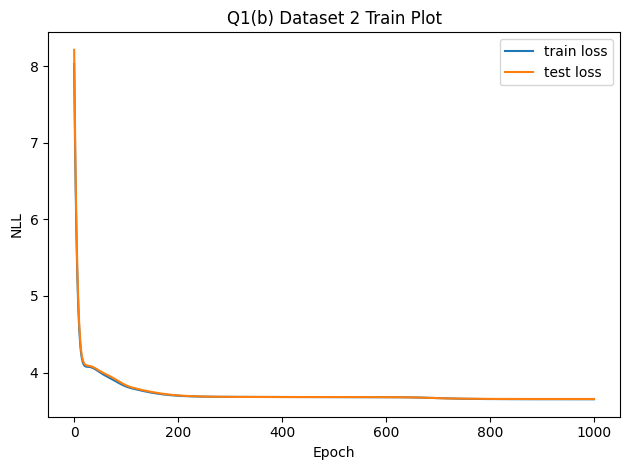

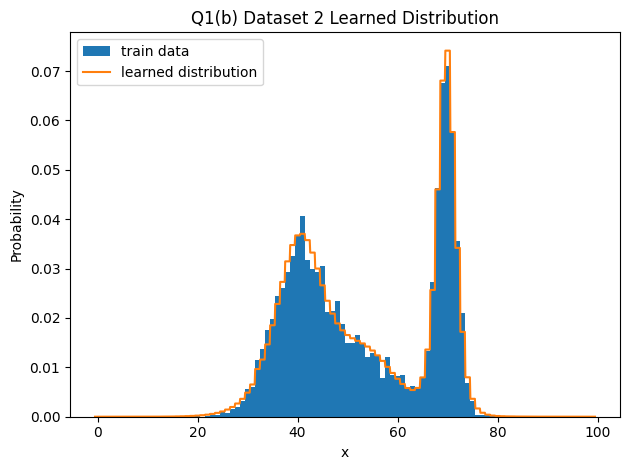

In [82]:
q1_save_results(2, "b", q1_b)

# Question 2 PixelCNNs

Now, you will train more powerful PixelCNN models on the shapes dataset and MNIST. In addition, we will extend to modeling colored datasets.

Run the cell below to visualize the two datasets binary datasets

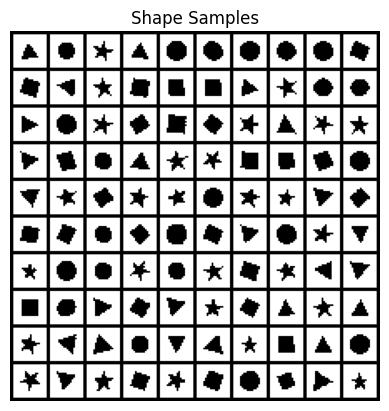

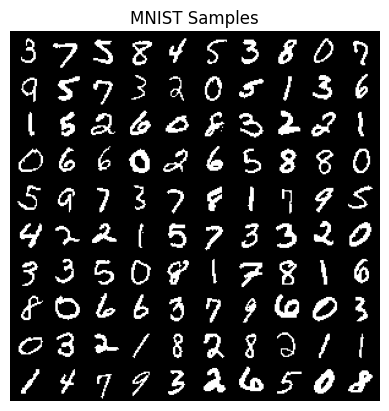

In [3]:
visualize_q2a_data(1)
visualize_q2a_data(2)

## Part (a) PixelCNN on Shapes and MNIST
In this part, implement a simple PixelCNN architecture to model binary MNIST and shapes images (same as Q2(b), but with a PixelCNN).

We recommend the following network design:
* A $7 \times 7$ masked type A convolution
* $5$ $7 \times 7$ masked type B convolutions
* $2$ $1 \times 1$ masked type B convolutions
* Appropriate ReLU nonlinearities in-between
* 64 convolutional filters

And the following hyperparameters:
* Batch size 128
* Learning rate $10^{-3}$
* 10 epochs
* Adam Optimizer (this applies to all PixelCNN models trained in future parts)

Your model should output logits, after which you could apply a sigmoid over 1 logit, or a softmax over two logits (either is fine). It may also help to scale your input to $[-1, 1]$ before running it through the network. 

Training on the shapes dataset should be quick, and MNIST should take around 10 minutes

Checkout the Paper for more details: https://arxiv.org/abs/1601.06759

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [4]:
from typing import Literal

MaskType = Literal["A", "B"]


class MaskConv2d(nn.Conv2d):
    def __init__(
        self,
        mask_type: MaskType,
        *args,
        color_conditioning=False,
        **kwargs,
    ):
        """2D Convolution with masked weight for AutoRegressive connection.

        Args:
            mask_type: Either "A" or "B". Determines which weights of the filter
                are used in the convolution.
            *args: Forwarded to `nn.Conv2d`.
            color_conditioning: Whether to use color conditioning or not.
            **kwargs: Forwarded to `nn.Conv2d`.
        """
        if mask_type not in ["A", "B"]:
            raise ValueError(f'Invalid mask type "{mask_type}"')

        super().__init__(*args, **kwargs)

        self.color_conditioning = color_conditioning

        # Make the mask a buffer since it's not a trainable parameter.
        # Shape: [out_channels, in_channels, kernel_size[0], kernel_size[1]
        self.register_buffer("mask", torch.zeros_like(self.weight))
        self._create_mask(mask_type)

    def forward(self, x):
        return F.conv2d(
            x,
            self.weight * self.mask,  # Apply the mask to the weights.
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )

    def _create_mask(self, mask_type):
        k = self.kernel_size[0]
        # Only allow (context) connections to pixels above and to the right.
        self.mask[:, :, : k // 2] = 1
        self.mask[:, :, k // 2, : k // 2] = 1

        if self.color_conditioning:
            if self.in_channels % 3 != 0:
                raise ValueError(
                    "Color conditioning can only be used when input has 3 channels."
                )
            if self.out_channels % 3 != 0:
                raise ValueError(
                    "Color conditioning can only be used when output has 3 channels."
                )

            one_third_in = self.in_channels // 3
            one_third_out = self.out_channels // 3
            if mask_type == "B":
                # Allow connection from the red channel to the red channel.
                self.mask[:one_third_out, :one_third_in, k // 2, k // 2] = 1
                # Allow connection from the green channel to the red and green
                # channels.
                self.mask[
                    one_third_out : 2 * one_third_out,
                    : 2 * one_third_in,
                    k // 2,
                    k // 2,
                ] = 1
                # Allow connection from the blue channel to the red, green, and
                # blue channels.
                self.mask[2 * one_third_out :, :, k // 2, k // 2] = 1
            else:
                # Allow connection from the green channel to the red channel.
                self.mask[
                    one_third_out : 2 * one_third_out, :one_third_in, k // 2, k // 2
                ] = 1
                # Alllow connection from the blue channel to the red and green
                # channels.
                self.mask[2 * one_third_out :, : 2 * one_third_in, k // 2, k // 2] = 1
        else:
            if mask_type == "B":
                # Allow connection from a channel to itself.
                self.mask[:, :, k // 2, k // 2] = 1


class ResBlock(nn.Module):
    def __init__(self, in_channels, **kwargs):
        super().__init__()
        self.block = nn.ModuleList(
            [
                nn.ReLU(),
                MaskConv2d("B", in_channels, in_channels // 2, 1, **kwargs),
                nn.ReLU(),
                # Use 7x7 convolution instead of 3x3 convolution (as in the original paper).
                MaskConv2d(
                    "B", in_channels // 2, in_channels // 2, 7, padding=3, **kwargs
                ),
                nn.ReLU(),
                MaskConv2d("B", in_channels // 2, in_channels, 1, **kwargs),
            ]
        )

    def forward(self, x):
        out = x
        for layer in self.block:
            out = layer(out)
        return out + x


class LayerNorm(nn.LayerNorm):
    def __init__(self, color_conditioning, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.color_conditioning = color_conditioning

    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        x_shape = x.shape
        if self.color_conditioning:
            x = x.contiguous().view(*(x_shape[:-1] + (3, -1)))
        x = super().forward(x)
        if self.color_conditioning:
            x = x.view(*x_shape)
        return x.permute(0, 3, 1, 2).contiguous()


class PixelCNN(nn.Module):
    def __init__(
        self,
        shape,
        num_colors,
        num_filters=64,
        kernel_size=7,
        num_layers=5,
        use_resblock=False,
        color_conditioning=False,
    ):
        """Initialize PixelCNN model.

        Args:
            shape: Shape of the input data in the order [num_channels, height, width].
            num_colors: Number of color categories in each channel. This is the
                number of colors that the dataset is quantized into. For example,
                if num_colors=4, then there are 4 colors and 2 bits per channel.
            num_filters: Number of convolutional filters.
            kernel_size: Kernel size for initial convolutional layers.
            num_layers: Number of masked type B convolutional layers.
            use_resblock: Whether to use ResBlocks instead of MaskedConv2d.
            color_conditioning: Whether to use color conditioning or not.
        """
        super().__init__()

        self.shape = shape
        self.num_colors = num_colors
        self.num_channels = shape[0]
        self.color_conditioning = color_conditioning

        if use_resblock:
            block_init = lambda: ResBlock(
                num_filters, color_conditioning=color_conditioning
            )
        else:
            block_init = lambda: MaskConv2d(
                "B",
                num_filters,
                num_filters,
                kernel_size=kernel_size,
                padding=kernel_size // 2,
                color_conditioning=color_conditioning,
            )

        model = nn.ModuleList(
            [
                MaskConv2d(
                    "A",
                    self.num_channels,
                    num_filters,
                    kernel_size=kernel_size,
                    padding=kernel_size // 2,
                    color_conditioning=color_conditioning,
                )
            ]
        )
        for _ in range(num_layers):
            if color_conditioning:
                model.append(LayerNorm(color_conditioning, num_filters // 3))
            else:
                model.append(LayerNorm(color_conditioning, num_filters))
            model.extend([nn.ReLU(), block_init()])
        model.extend(
            [
                nn.ReLU(),
                MaskConv2d(
                    "B",
                    num_filters,
                    num_filters,
                    1,
                    color_conditioning=color_conditioning,
                ),
            ]
        )
        model.extend(
            [
                nn.ReLU(),
                MaskConv2d(
                    "B",
                    num_filters,
                    num_colors * self.num_channels,
                    1,
                    color_conditioning=color_conditioning,
                ),
            ]
        )

        self.net = model

    def forward(self, x):
        batch_size = x.shape[0]
        out = (x.float() / (self.num_colors - 1) - 0.5) / 0.5
        for layer in self.net:
            out = layer(out)

        if self.color_conditioning:
            # Shape: [batch_size, num_colors, num_channels, height, width]
            return out.view(
                batch_size, self.num_channels, self.num_colors, *self.shape[1:]
            ).permute(0, 2, 1, 3, 4)
        else:
            # Shape: [batch_size, num_colors, height, width]
            return out.view(batch_size, self.num_colors, *self.shape)

    def loss(self, x):
        return F.cross_entropy(self(x), x.long())

    def sample(self, n):
        """Samples `n` images from the model.
        Args:
            n: Number of images to sample.

        Returns:
            Samples of shape [n, height, width, num_channels].
        """
        # Shape: [n, num_channels, height, width]
        samples = torch.zeros(n, *self.shape).cuda()
        with torch.no_grad():
            for r in range(self.shape[1]):
                for c in range(self.shape[2]):
                    for k in range(self.num_channels):
                        logits = self(samples)[:, :, k, r, c]
                        probs = F.softmax(logits, dim=1)
                        samples[:, k, r, c] = torch.multinomial(probs, 1).squeeze(-1)
        return samples.permute(0, 2, 3, 1).cpu().numpy()

In [78]:
def q2_a(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
    image_shape: (H, W), height and width of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in {0, 1}
    """
    train_data = np.transpose(train_data, (0, 3, 1, 2))
    test_data = np.transpose(test_data, (0, 3, 1, 2))

    H, W = image_shape
    model = PixelCNN((1, H, W), 2, num_layers=5).cuda()

    train_loader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=128)
    train_losses, test_losses = train(model, train_loader, test_loader, 10, 1e-3)
    samples, _ = model.sample(100)
    return train_losses, test_losses, samples

### Results

Once you've implemented `q2_a`, execute the cells below to visualize and save your results



Final Test Loss: 0.0396


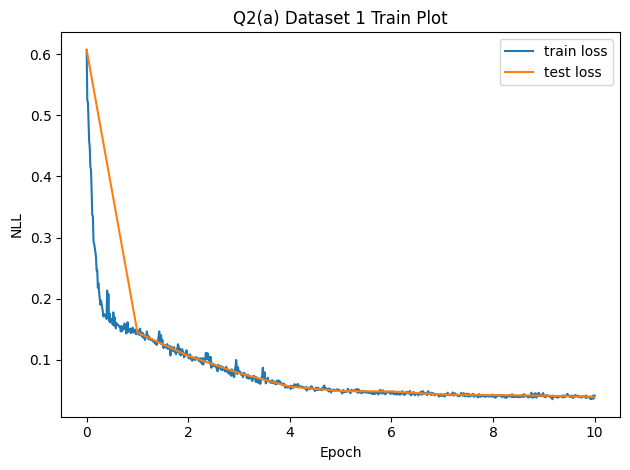

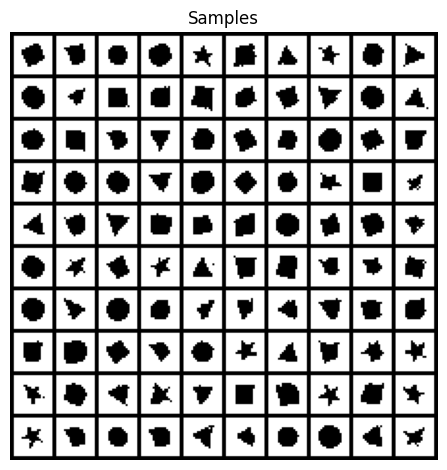

In [31]:
q2a_save_results(1, q2_a)

Final Test Loss: 0.0757


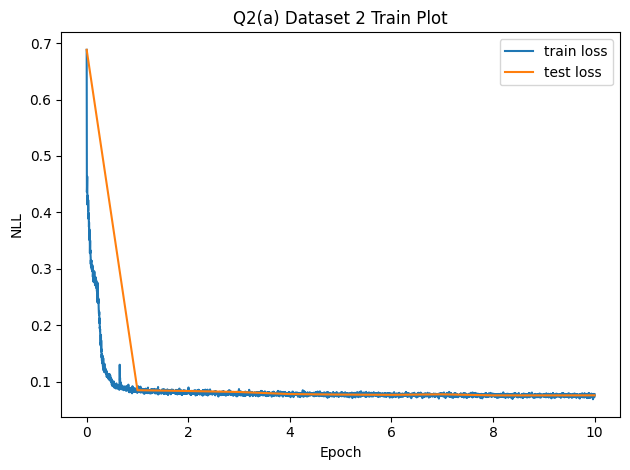

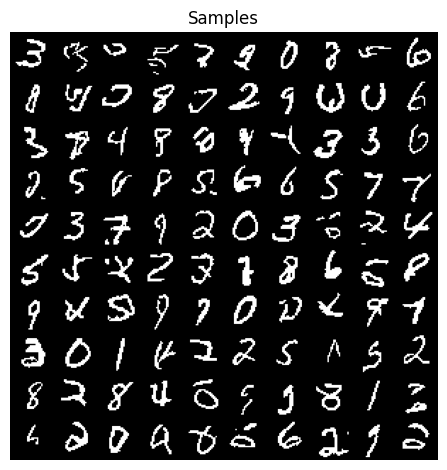

In [6]:
q2a_save_results(2, q2_a)

## Part (b) PixelCNN on Colored Shapes and MNIST: Independent Color Channels

For the next part, we'll work with color images (shapes and MNIST). Run the cell below to visualize the dataset.

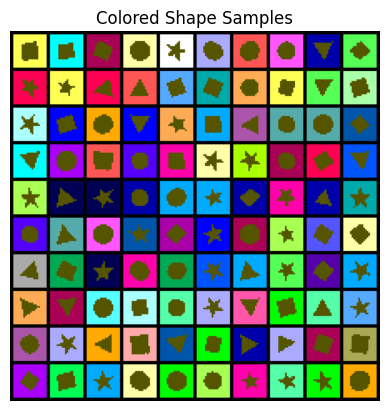

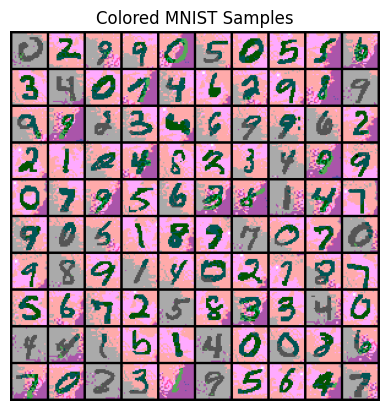

In [32]:
visualize_q2b_data(1)
visualize_q2b_data(2)

Now, implement a PixelCNN to support RGB color channels (or augment your existing implementation). **First, implement a PixelCNN that assumes color channels as independent.** More formally, we model the following parameterized distribution:

$$p_\theta(x) = \prod_{i=1}^{HW}\prod_{c=1}^C p_\theta(x_i^c | x_{<i})$$

Here are some tips that you may find useful for designing and training these models:
* You will need a 4-way softmax for every prediction, as opposed to a 256-way softmax in the PixelCNN paper, since the dataset is quantized to two bits per color channel
* You can set the number of filters for each convolutions to 120. You can use the ReLU nonlinearity throughout.
* Use a stack of 8 residual block architecture from [Figure 5](https://arxiv.org/abs/1601.06759) but with 7 x 7 masked convolutions in the middle instead of 3 x 3 masked convolutions
* Consider using [layer normalization](https://arxiv.org/abs/1607.06450) to improve performance. However, be careful to maintain the autoregressive property.
* With a learning rate of $10^{-3}$ and a batch size of 128, it should take a few minutes to run on the shapes dataset, and about 50-60 minutes on MNIST.

**You will provide these deliverables**


1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model



Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [79]:
def q2_b(train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: (H, W, C), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
    """
    # Reshape to [batch_size, C, H, W] for PixelCNN/Conv2D compatibility.
    train_data = np.transpose(train_data, (0, 3, 1, 2))
    test_data = np.transpose(test_data, (0, 3, 1, 2))

    H, W, C = image_shape
    num_colors = 4
    epochs = 15
    lr = 1e-3
    num_filters = 120
    num_layers = 8
    batch_size = 128
    model = PixelCNN(
        (C, H, W),
        num_colors,
        num_filters=num_filters,
        num_layers=num_layers,
        use_resblock=True,
    ).cuda()

    train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=batch_size)
    train_losses, test_losses = train(model, train_loader, test_loader, epochs, lr)
    samples, _ = model.sample(100)
    return train_losses, test_losses, samples

### Results

Once you've implemented `q2_b`, execute the cells below to visualize and save your results



Final Test Loss: 0.0425


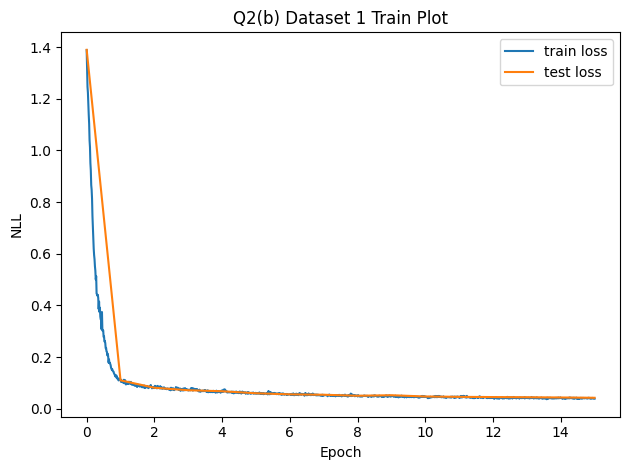

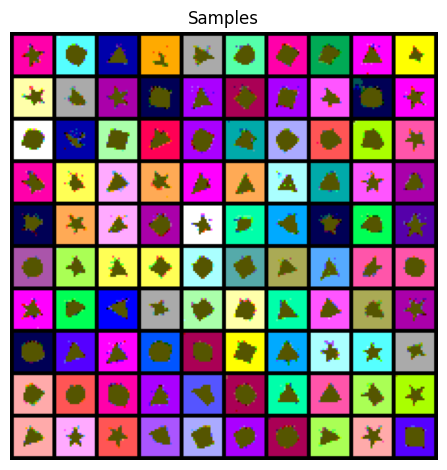

In [35]:
q2b_save_results(1, "b", q2_b)

Final Test Loss: 0.0892


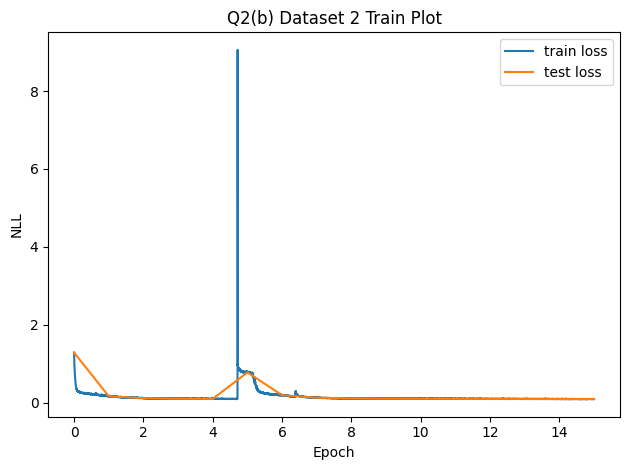

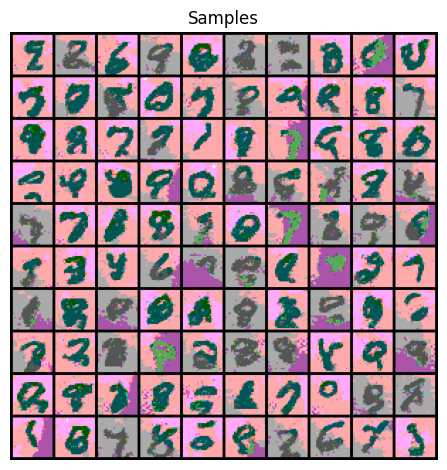

In [36]:
q2b_save_results(2, "b", q2_b)

# Question 3: Causal Transformer - iGPT

Now we will move onto the current most popular and widespread autoregressive model, the transformer.

## Part (a) Autoregressive Transformer on Shapes and MNIST
In this part, implement a simple Autoregressive Transformer to model binary MNIST and shapes images (same as Q2(a), but with a Transformer). 

Some additional notes about your transformer implementation:
 * iGPT uses learned positional encodings. Use those here as well.
 * Autoregressive transformer always predicts the **next** token, give prior tokens. iGPT has a special **\<bos\>** or beginning of sequence token at the start of every sequence every image. Make sure to include this in your implementation as well. You can generate unconditional sample by conditioning with the **\<bos\>** token.
 * While dropout is a common feature in transformer models, you do not need to add it (but may if you wish!).
 * Prebuilt transformers exist in some frameworks (i.e. pytorch). Don't just use an off the shelf implementation as the point of the exercise is to better understand the transformer architecture. Building the transformer from the ground up (use primitives such as Linear/Dense layers, LayerNorm, GeLU, Embedding)
 * Learning rate warmup and cos learning rate decay are often used when training transformers to improve training stability and improve performance. See if this helps your model! Try 1000 steps of warmup with a cosine learning rate decay.

Paper references
* [Attention Is All You Need](https://arxiv.org/abs/1706.03762) 
* [Generative Pretraining from Pixels](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf) 
* [Language Models are Unsupervised Multitask Learners](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)

We recommend the following network design parameters:
* $d_{model}$: 128
* heads: 4
* layers: 2
* GeLU nonlinearities

And the following hyperparameters:
* Batch size: 64 or 32 or 16 (whichever fits in your GPU)
* Learning rate: $10^{-3}$
* 15 epochs or more
* Adam Optimizer (this applies to all Transformers models trained in future parts)

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. 100 samples from the final trained model



In [2]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, seq_len):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.depth = d_model // num_heads

        # Linear layers that project the input to Q, K, and V for all heads.
        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)

        self.dense = nn.Linear(d_model, d_model)

        # Create a mask for autoregressive property.
        # 0 means valid position, 1 means masked position.
        mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1)
        mask = mask.masked_fill(mask == 1, -1e9)
        self.register_buffer("mask", mask)

        self.cache = None

    def split_heads(self, x, batch_size):
        """Split x into self.num_heads pieces.

        Args:
            x: Tensor of shape (batch_size, seq_len, d_model)
            batch_size: Batch size

        Returns:
            Tensor of shape (batch_size, num_heads, seq_len, depth)
        """
        # Shape: [batch_size, seq_len, num_heads, depth]
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        return x.permute(0, 2, 1, 3)

    # def forward(self, q, k, v, use_cache=False):
    #     """Apply forward pass.

    #     Args:
    #         q: Query tensor of shape (batch_size, seq_len, d_model)
    #         k: Key tensor of shape (batch_size, seq_len, d_model)
    #         v: Value tensor of shape (batch_size, seq_len, d_model)
    #         mask: Mask tensor of shape (batch_size, seq_len).
    #             0 means valid position, 1 means masked position.
    #     """
    #     batch_size = q.size(0)

    #     if use_cache and self.cache is not None:
    #         cache_k = self.cache["k"]
    #         cache_v = self.cache["v"]

    #     q = self.split_heads(self.wq(q), batch_size)
    #     k = self.split_heads(self.wk(k), batch_size)
    #     v = self.split_heads(self.wv(v), batch_size)

    #     scaled_attention_logits = (
    #         torch.matmul(q, k.transpose(-2, -1)) / self.depth**0.5
    #     )

    #     # Apply mask to the scaled attention logits
    #     seq_len = q.size(2)
    #     scaled_attention_logits += self.mask[:seq_len, :seq_len]

    #     attention_weights = F.softmax(scaled_attention_logits, dim=-1)

    #     output = torch.matmul(attention_weights, v)
    #     # Concatenate the output of all heads
    #     output = (
    #         output.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.d_model)
    #     )

    #     return self.dense(output)

    def forward(self, q, k, v, use_cache=False):
        """Apply forward pass.

        Args:
            q: Query tensor of shape (batch_size, seq_len, d_model)
            k: Key tensor of shape (batch_size, seq_len, d_model)
            v: Value tensor of shape (batch_size, seq_len, d_model)
            use_cache: Whether to use cache for fast decoding. If True, q, k, and v
                have shape (batch_size, 1, d_model).

        Returns:
            Hidden state tensor of shape (batch_size, seq_len, d_model).
        """
        batch_size = q.size(0)

        # [batch_size, num_heads, 1, depth]
        q = self.split_heads(self.wq(q), batch_size)
        k = self.split_heads(self.wk(k), batch_size)
        v = self.split_heads(self.wv(v), batch_size)

        if use_cache:
            if self.cache is not None:
                # Concatenate with the cached keys and values
                # [batch_size, num_heads, seq_len, depth]
                k = torch.cat([self.cache["k"], k], dim=2)
                v = torch.cat([self.cache["v"], v], dim=2)
            # Update cache
            self.cache = {"k": k, "v": v}

        # [batch_size, num_heads, seq_len, seq_len]
        scaled_attention_logits = torch.matmul(q, k.transpose(-2, -1)) / self.depth**0.5

        # Apply mask to the scaled attention logits if not using cache.
        if not use_cache:
            seq_len = q.size(2)
            scaled_attention_logits += self.mask[:seq_len, :seq_len]

        # Shape: [batch_size, num_heads, seq_len, seq_len]
        attention_weights = F.softmax(scaled_attention_logits, dim=-1)

        # Shape: [batch_size, num_heads, seq_len, depth]
        output = torch.matmul(attention_weights, v)
        # Concatenate the output of all heads
        output = (
            output.permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.d_model)
        )

        return self.dense(output)

    def clear_cache(self):
        self.cache = None

    def is_cache_empty(self):
        return self.cache is None


class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=2048):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.linear2(F.gelu(self.linear1(x)))


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len):
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        # Exponentiate at the end for numerical stability
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        # Shape: [batch_size=1, max_len, d_model]
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        # Shape: [batch_size, seq_len, d_model]
        return self.pe[:, : x.size(1)].repeat(x.size(0), 1, 1)

    def encoding_for_last_token(self, x):
        return self.pe[:, x.size(1) : x.size(1) + 1].repeat(x.size(0), 1, 1)


class TransformerBlock(nn.Module):
    def __init__(self, seq_len, d_model, num_heads, dropout):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, num_heads, seq_len)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.ffn = FeedForward(d_model)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, use_cache=False):
        attn_output = self.attention(x, x, x, use_cache=use_cache)
        x = self.norm1(x + self.dropout(attn_output))
        ffn_output = self.ffn(x)
        x = self.norm2(x + self.dropout(ffn_output))
        return x

    def clear_cache(self):
        self.attention.clear_cache()

    def is_cache_empty(self):
        return self.attention.is_cache_empty()


class Transformer(nn.Module):
    def __init__(self, seq_len, vocab_size, num_layers, d_model, num_heads, dropout):
        super().__init__()
        self.layers = nn.ModuleList(
            [
                TransformerBlock(seq_len, d_model, num_heads, dropout)
                for _ in range(num_layers)
            ]
        )

        self.embedding = nn.Embedding(vocab_size, d_model)

        self.pos_encoding = PositionalEncoding(d_model, seq_len)

        self.norm = nn.LayerNorm(d_model)
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, x, use_cache=False):
        # x initially has shape [batch_size, seq_len]
        # Only pass the last token through the network if using cache and the
        # cache is not empty for all of the transformer blocks. The cache may be
        # empty if the model is being conditioned on a partial sequence.
        if use_cache and not any(layer.is_cache_empty() for layer in self.layers):
            pos_encoding = self.pos_encoding.encoding_for_last_token(x)
            x = x[:, -1:]
        else:
            pos_encoding = self.pos_encoding(x)

        # Shape: [batch_size, seq_len, d_model]
        x = self.embedding(x) + pos_encoding
        for layer in self.layers:
            x = layer(x, use_cache=use_cache)
        # Shape: [batch_size, seq_len, vocab_size]
        x = self.fc(self.norm(x))
        # Shape: [batch_size, vocab_size, seq_len]
        return x.transpose(1, 2)

    def clear_cache(self):
        for layer in self.layers:
            layer.clear_cache()


def train_transformer(
    model,
    train_dataloader,
    test_dataloader,
    epochs,
    lr,
    # warmup_steps,
    device="cuda",
    verbose=False,
):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=len(train_dataloader) * epochs
    )

    # Cross-entropy loss
    criterion = nn.CrossEntropyLoss()

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        # Evaluate on the test set
        model.eval()
        with torch.no_grad():
            test_loss = 0
            for test_batch in test_dataloader:
                test_batch = test_batch.to(device).long()
                logits = model(test_batch)
                test_loss += (
                    criterion(logits[..., :-1], test_batch[..., 1:]).item()
                    * test_batch.shape[0]
                )
            test_loss /= len(test_dataloader.dataset)
            test_losses.append(test_loss)

        model.train()
        total_loss = 0
        for batch_idx, train_batch in enumerate(train_dataloader):
            train_batch = train_batch.to(device).long()
            optimizer.zero_grad()
            logits = model(train_batch)
            loss = criterion(logits[..., :-1], train_batch[..., 1:])
            loss.backward()
            optimizer.step()
            scheduler.step()

            loss_value = loss.item()
            train_losses.append(loss_value)
            total_loss += loss_value

        if verbose:
            print(
                f"Epoch {epoch}, Train Loss: {total_loss / len(train_dataloader)}, Test Loss: {test_loss}"
            )

    return train_losses, test_losses


def sample(
    model,
    num_samples,
    seq_len,
    device,
    bos_token,
    use_cache=True,
    prevent_sampling_bos=True,
):
    model.eval()
    if use_cache:
        model.clear_cache()

    # [num_samples, seq_len]
    samples = torch.full(
        (num_samples, 1), fill_value=bos_token, dtype=torch.long, device=device
    )  # Initialize with <bos> token

    time_list = []

    for i in range(seq_len):
        start = time.time()
        # Shape: [num_samples, vocab_size, seq_len]
        logits = model(samples, use_cache=use_cache)
        time_delta = time.time() - start
        if i > 0:
            time_list.append(time_delta)
        if prevent_sampling_bos:
            # Prevent sampling the <bos> token again
            logits[:, bos_token] = -1e10
        # Shape: [num_samples, vocab_size, seq_len]
        probs = F.softmax(logits, dim=1)
        # Shape: [num_samples, seq_len] (seq_len = 1 if use_cache=True)
        next_token = torch.multinomial(probs[:, :, -1], 1)
        samples = torch.cat([samples, next_token], dim=1)

    # Remove the BOS token.
    samples = samples[:, 1:]

    return np.asarray(samples.cpu()), time_list

In [4]:
def q3_a(train_data, test_data, image_shape, dset_id, generate=True):
    """
    train_data: A (n_train, H, W, 1) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, 1) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: (H, W, 1), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, 1) of samples with values in {0, 1, 2, 3}
    """
    np.random.seed(0)
    torch.manual_seed(0)

    height, width, channel = train_data.shape[1:]
    assert channel == 1
    # Shape: [batch_size, seq_len]
    train_data = train_data.reshape(-1, height * width).astype(np.int32)
    test_data = test_data.reshape(-1, height * width).astype(np.int32)

    # Prepend BOS token to the input
    BOS_TOKEN = 2
    fill_tensor = np.full((train_data.shape[0], 1), BOS_TOKEN)
    train_data = np.concatenate((fill_tensor, train_data), axis=1)

    if dset_id == 1:
        batch_size = 16
    else:
        batch_size = 64

    train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=batch_size)

    seq_len = train_data.shape[1]
    vocab_size = 3
    epochs = 15
    lr = 1e-3
    num_layers = 2
    d_model = 128
    num_heads = 4
    dropout = 0.0

    model = Transformer(
        seq_len, vocab_size, num_layers, d_model, num_heads, dropout
    ).cuda()

    verbose = True

    train_losses, test_losses = train_transformer(
        model, train_loader, test_loader, epochs, lr, verbose=verbose
    )

    if verbose:
        print("Sampling...")

    if generate:
        samples, _ = sample(
            model, 100, height * width, "cuda", BOS_TOKEN, use_cache=True
        )
        samples = samples.reshape(samples.shape[0], height, width)[..., np.newaxis]
    else:
        samples = None

    return train_losses, test_losses, samples, model

### Results

Once you've implemented `q3_a`, execute the cells below to visualize and save your results

Epoch 0, Train Loss: 0.10292981445561838, Test Loss: 1.3816401805571898
Epoch 1, Train Loss: 0.062301633780011696, Test Loss: 0.11513960392338161
Epoch 2, Train Loss: 0.05145164704277315, Test Loss: 0.1416129558694519
Epoch 3, Train Loss: 0.04698076195275511, Test Loss: 0.1343631803212997
Epoch 4, Train Loss: 0.04427863953791502, Test Loss: 0.14449374692938
Epoch 5, Train Loss: 0.04203938291841791, Test Loss: 0.13697272975788274
Epoch 6, Train Loss: 0.04040534384548664, Test Loss: 0.12674395874079605
Epoch 7, Train Loss: 0.038716501768194994, Test Loss: 0.1278398097908542
Epoch 8, Train Loss: 0.03758508612238269, Test Loss: 0.14738396565968834
Epoch 9, Train Loss: 0.036269360061251484, Test Loss: 0.13966722806666376
Epoch 10, Train Loss: 0.035068936063019376, Test Loss: 0.14588396160620087
Epoch 11, Train Loss: 0.03404494233656931, Test Loss: 0.14733597974659365
Epoch 12, Train Loss: 0.03312811648174552, Test Loss: 0.15414191473568237
Epoch 13, Train Loss: 0.03246415437746594, Test Los

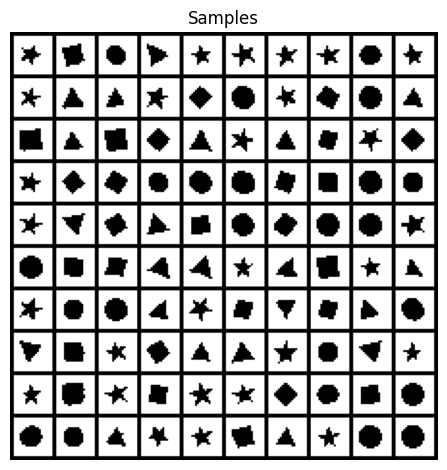

In [64]:
train_losses, test_losses, samples, model = q3ab_save_results(
    1, "a", q3_a, generate=True, save=False
)

In [6]:
train_losses, test_losses, samples, model = q3ab_save_results(2, "a", q3_a)

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


## Part (b) iGPT on Colored Shapes and MNIST: Independent Color Channels

Now, implement an iGPT that models color channels (Like Question 2(b) except with the Transformer). In order to reduce the length of token sequences, iGPT models each RGB pixel as a **single** token. This effectively reduces the context length from H*W*C to just H*W. iGPT does this through a k-means clustering approach. Because our images only each can only take on 4 values (2 bits) per channel, we can represent each pixel with 64 values (6 bits). Convert the dataset into an image of tokens and train iGPT on the colored shapes and MNIST dataset.

Checkout the iGPT paper for more details: [Generative Pretraining from Pixels](https://cdn.openai.com/papers/Generative_Pretraining_from_Pixels_V2.pdf) 

Training times and hyperparameter settings should be the same as part (a), except train for longer (15 epochs)

**You will provide these deliverables**

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from the final trained model


In [9]:
class ColoredImageTokenizer:
    def __init__(self, num_colors_per_channel=4):
        self.base = num_colors_per_channel

    def encode(self, x):
        # x has shape [batch_size, height, width, num_channels]
        num_channels = x.shape[-1]
        base_arr = np.array([self.base**i for i in range(num_channels)])
        # Shape: [batch_size, height, width]
        return x.dot(base_arr)

    def decode(self, x):
        # x has shape [batch_size, height, width]
        x_decoded = np.zeros(x.shape + (3,), dtype=np.float32)
        x_decoded[..., 0] = x % self.base
        x_decoded[..., 1] = (x // self.base) % self.base
        x_decoded[..., 2] = (x // (self.base**2)) % self.base
        return x_decoded

In [10]:
def q3_b(train_data, test_data, image_shape, dset_id, generate=True):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: (H, W, C), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, W, C) of samples with values in {0, 1, 2, 3}
    """
    if dset_id == 1:
        batch_size = 16
    elif dset_id == 2:
        batch_size = 64

    epochs = 1
    lr = 1e-3
    num_layers = 2
    d_model = 128
    num_heads = 4
    dropout = 0.0
    verbose = True

    np.random.seed(0)
    torch.manual_seed(0)

    height, width, num_channels = train_data.shape[1:]
    assert num_channels == 3

    # Tokenize the input
    tokenizer = ColoredImageTokenizer(4)
    train_data = tokenizer.encode(train_data)
    test_data = tokenizer.encode(test_data)

    # Shape: [batch_size, seq_len]
    train_data = train_data.reshape(-1, height * width).astype(np.int32)
    test_data = test_data.reshape(-1, height * width).astype(np.int32)

    # Prepend BOS token to the input
    BOS_TOKEN = 64
    fill_tensor = np.full((train_data.shape[0], 1), BOS_TOKEN)
    train_data = np.concatenate((fill_tensor, train_data), axis=1)

    train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=batch_size)

    seq_len = train_data.shape[1]
    vocab_size = 65

    model = Transformer(
        seq_len, vocab_size, num_layers, d_model, num_heads, dropout
    ).cuda()

    train_losses, test_losses = train_transformer(
        model, train_loader, test_loader, epochs, lr, verbose=verbose
    )

    if verbose:
        print("Sampling...")

    if generate:
        num_samples = 100
        samples, _ = sample(
            model, num_samples, height * width, "cuda", BOS_TOKEN, use_cache=True
        )
        samples = samples.reshape(samples.shape[0], height, width)
        samples = tokenizer.decode(samples)
    else:
        samples = None

    return train_losses, test_losses, samples, model

### Results

Once you've implemented `q3_b`, execute the cells below to visualize and save your results

Epoch 0, Train Loss: 0.20118908454443662, Test Loss: 4.194905164591641
Sampling...
Final Test Loss: 4.1949


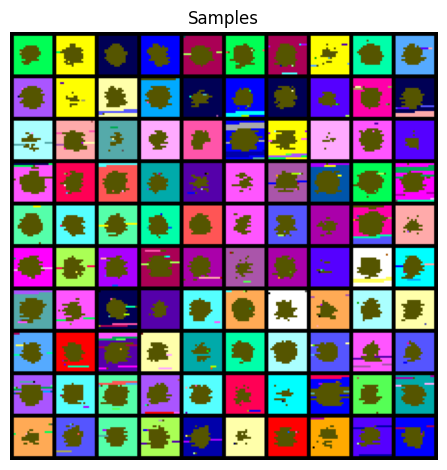

In [11]:
train_losses, test_losses, samples, model = q3ab_save_results(
    1, "b", q3_b, generate=True, save=False
)

Epoch 0, Train Loss: 0.3836225080053012, Test Loss: 4.463382907867432
Epoch 1, Train Loss: 0.15179956774910291, Test Loss: 0.31310156598091127
Epoch 2, Train Loss: 0.1220748006482919, Test Loss: 0.31060054960250855
Epoch 3, Train Loss: 0.11148394698301951, Test Loss: 0.3304513593196869
Epoch 4, Train Loss: 0.10447233943939209, Test Loss: 0.3552941131591797
Epoch 5, Train Loss: 0.09933450074593227, Test Loss: 0.3715723071575165
Epoch 6, Train Loss: 0.09564717725714048, Test Loss: 0.36819226613044737
Epoch 7, Train Loss: 0.09263109185496966, Test Loss: 0.37377071046829224
Epoch 8, Train Loss: 0.09023166653513909, Test Loss: 0.41934705157279967
Epoch 9, Train Loss: 0.0882372031013171, Test Loss: 0.4254612729549408
Epoch 10, Train Loss: 0.08664120584130287, Test Loss: 0.4388323371887207
Epoch 11, Train Loss: 0.08535128961602846, Test Loss: 0.4517972677230835
Epoch 12, Train Loss: 0.0843871417939663, Test Loss: 0.4592496308326721
Epoch 13, Train Loss: 0.08369833112557729, Test Loss: 0.48929

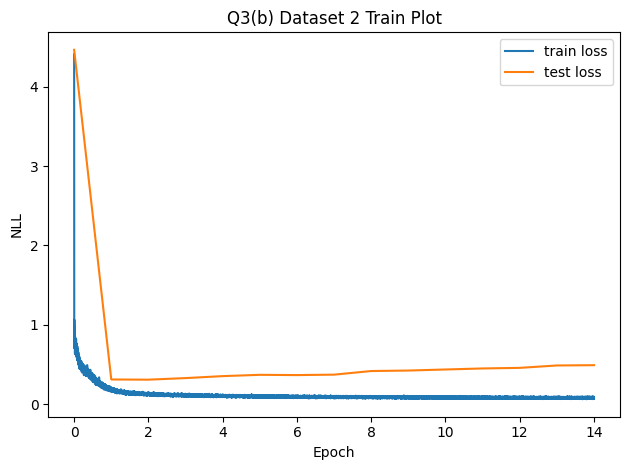

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


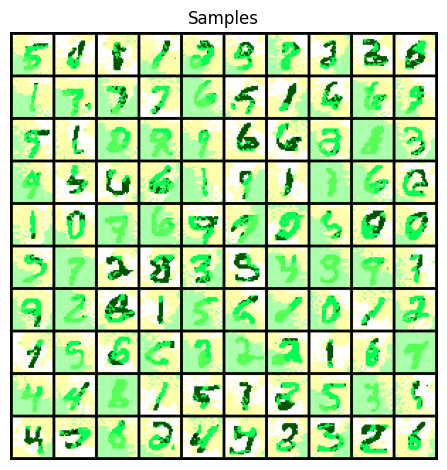

In [38]:
train_losses, test_losses, samples, model = q3ab_save_results(2, "b", q3_b)

## Part (c) K, V Caching for Improved Inference
You may have noticed that generation from the transformer is quite slow. Part of this is just due to the autoregressive nature. However, another part is due to some computational inefficiency. At each forward pass of the model, we are performing repeat computation of the past sequence. Specifically, we can cache the key and values at the multi attention layer to more quickly predict at each step.

In self-attention, a sequence is processed by generating three vectors for each element in the sequence: a Query (Q), a Key (K), and a Value (V). These vectors are then used to compute attention scores and subsequently the output of the attention layer.
Mathematically, this can be represented as:
 * For each index $i$, compute $Q_i$, $K_i$, $V_i$ for the current element
 * Retrieve $K_{<i}$ and $V_{<i}$ from the cache (where $<i$ denotes all indices before the current one)
 * Compute the attention output using $Q_i$, $[K_{<i}, K_i]$, $[V_{<i}, V_i]$


Next implement caching for your transformer to make inference more efficient by modifying your self attention. Use caching for inference in the future problems for faster generation! (Note caching is only used during inference). You will use the same dataset as in part B, dataset 2 of this question (colored mnist). No training is required in this section, feel free to reuse the model you trained in part B, dataset 2.

**You will provide these deliverables**

1. Over the course of inference, measure the time for the forward pass over the total sequence length with and without caching.
3. 100 samples from the final trained model using the caching inference pipeline.



In [12]:
def q3_c(model, train_data, test_data, image_shape, dset_id):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: (H, W, C), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, C, W) of samples with values in {0, 1, 2, 3}
    """
    num_samples = 100
    height, width = train_data.shape[1], train_data.shape[2]
    BOS_TOKEN = 64

    base = 4
    tokenizer = ColoredImageTokenizer(base)

    samples_lists = []
    time_lists = []
    for use_cache in [True, False]:
        torch.manual_seed(0)
        np.random.seed(0)

        samples, time_list = sample(
            model, num_samples, height * width, "cuda", BOS_TOKEN, use_cache=use_cache
        )
        samples = samples.reshape(samples.shape[0], height, width)
        samples = tokenizer.decode(samples)
        samples_lists.append(samples)
        time_lists.append(time_list)

    time_list_with_cache, time_list_no_cache = time_lists
    samples_with_cache, samples_no_cache = samples_lists

    return (
        time_list_no_cache,
        time_list_with_cache,
        samples_no_cache,
        samples_with_cache,
    )

### Results

Once you've implemented `q3_c`, execute the cells below to visualize and save your results



In [13]:
from importlib import reload

del q3c_save_results
reload(hw1_helper)
from deepul.hw1_helper import q3c_save_results

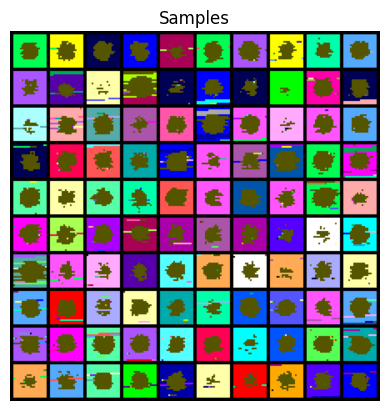

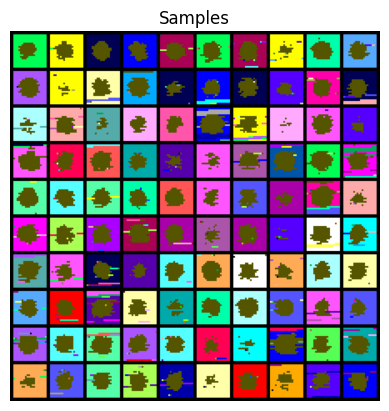

In [14]:
(
    time_list_no_cache,
    time_list_with_cache,
    samples_no_cache,
    samples_with_cache,
) = q3c_save_results(1, q3_c, model, save=False)

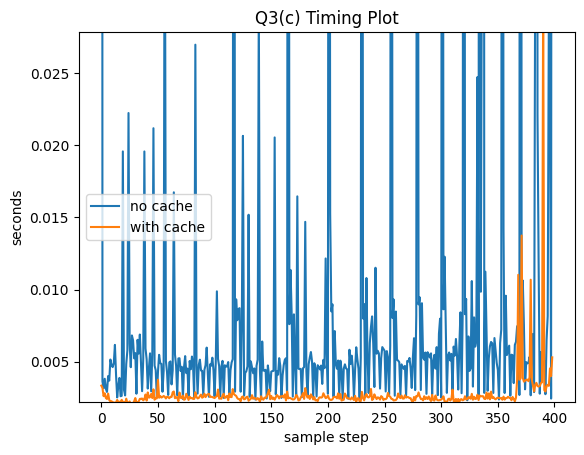

In [20]:
def save_timing_plot(
    time_1: np.ndarray,
    time_2: np.ndarray,
    title: str,
    fname: str,
    time1_label: str,
    time2_label: str,
) -> None:
    plt.figure()

    plt.plot(time_1, label=time1_label)
    plt.plot(time_2, label=time2_label)

    lower_limit = min(np.percentile(time_1, 5), np.percentile(time_2, 5))
    upper_limit = max(np.percentile(time_1, 95), np.percentile(time_2, 95))
    plt.ylim(lower_limit, upper_limit)

    plt.legend()
    plt.title(title)
    plt.xlabel("sample step")
    plt.ylabel("seconds")
    if fname is not None:
        savefig(fname)


save_timing_plot(
    time_list_no_cache,
    time_list_with_cache,
    "Q3(c) Timing Plot",
    None,
    time1_label="no cache",
    time2_label="with cache",
)

In [15]:
q3c_save_results(2, q3_c, model)

In [87]:
model

Transformer(
  (layers): ModuleList(
    (0-1): 2 x TransformerBlock(
      (attention): MultiHeadAttention(
        (wq): Linear(in_features=128, out_features=128, bias=True)
        (wk): Linear(in_features=128, out_features=128, bias=True)
        (wv): Linear(in_features=128, out_features=128, bias=True)
        (dense): Linear(in_features=128, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (ffn): FeedForward(
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
  )
  (embedding): Embedding(65, 128)
  (pos_encoding): PositionalEncoding()
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=128, out_features=65, bias=True)
)

# Question 4: Causal Transformer: Tokenized Images

## Image Tokenization with Vector Quanization

## Part (a) Image Quantization

Above, we implemented iGPT, which autoregressivly predicts raw pixels. Transformers have quadratic complexity in the sequence length which prevents this naive approach from scaling well to large images.

The space of natural images often contains very correlated information. This suggests we can learn a reduced representation. VQVAE is a method that does just that, learning to map images to a more compact discrete set of tokens. We will cover this method in more detail in future lectures. The only thing you need to know now is that we can learn an encoder (and corresponding decoder), which can extract a discrete representation from an image. 

If you are curious, checkout the VQVAE paper to learn more: https://arxiv.org/abs/1711.00937 (we will cover this in a future lecture though!)

In this part, we provide a pre-trained VQVAE model, which consists of:
 * encoder to tokenize the images
 * the decoder to recover the image
 * a token vocabulary of VQVAE_MODEL.n_embeddings

Below is the code for loading the VQ model. Note that VQVAE encoding process is lossy, so the decoded images will not be the exact same as the input. Some blurriness in the recovered image is to be expected. The docstrings of the relevant methods you will need for the VQVAE_MODEL are provided below for your convenience. 

We will use 2 colored mnist datasets in this part. The first is the same dataset used in previous parts. The second, hads a colored digit on a differently colored background. We will call these datasets Colored MNIST and Colored MNIST v2. Note that the vqvae is trained per dataset.

**You will provide these deliverables**

1. Use the provided encoder model to quantize the images then inspect the recovered images by applying the decoder for each of the two datasets

In [ ]:
# @property
# def n_embeddings(self) -> int:
#     """The size of the token vocabulary"""
#
# def quantize(self, x: np.ndarray) -> np.ndarray:
#     """Quantize an image x.
#
#     Args:
#         x (np.ndarray, dtype=int): Image to quantize. shape=(batch_size, 28, 28, 3). Values in [0, 3].
#
#     Returns:
#         np.ndarray: Quantized image. shape=(batch_size, 7, 7). Values in [0, n_embeddings]
#     """
#
# def decode(self, z_index: np.ndarray) -> np.ndarray:
#     """Decode a quantized image.
#
#     Args:
#         z_index (np.ndarray, dtype=int): Quantized image. shape=(batch_size, 7, 7). Values in [0, n_embeddings].
#
#     Returns:
#         np.ndarray: Decoded image. shape=(batch_size, 28, 28, 3). Values in [0, 3].
#     """
#

In [21]:
def q4_a(images, vqvae):
    """
    images: (B, H, W, C), the images to pass through the encoder and decoder of the vqvae
    vqvae: a vqvae model, trained on the relevant dataset

    Returns
    - a numpy array of size (2, H, W, C) of the decoded image
    """
    encoded_images = vqvae.quantize(images)
    autoencoded_images = vqvae.decode(encoded_images)
    return autoencoded_images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


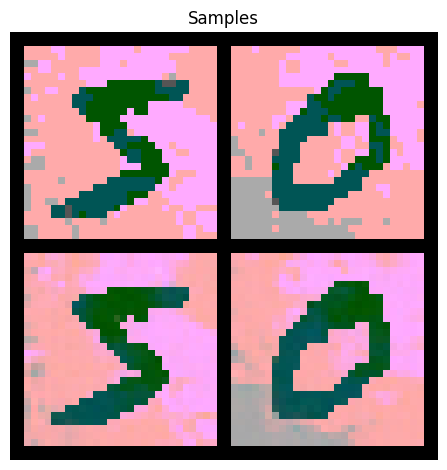

In [22]:
q4a_save_results(1, q4_a)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


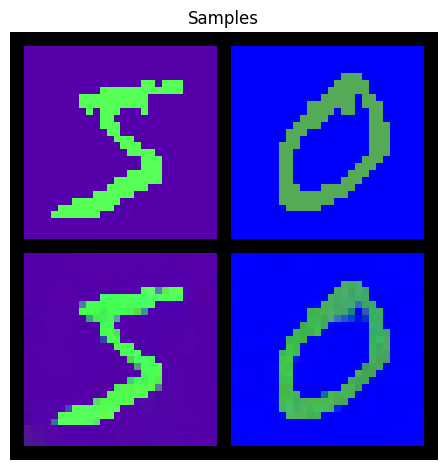

In [23]:
q4a_save_results(2, q4_a)

## Part (b) Autoregressive Transformer on Colored Shapes and MNIST: Independent Color Channels with Vector Quantization

We can use the VQVAE to tokenize an image dataset. This will result in a much smaller sequence length than the approach we tried in Question 3(b). For this part, train a transformer on the dataset tokenized by the VQVAE.

This is a simplified version of the approach used in VQGAN [VQGAN](https://arxiv.org/abs/2012.09841) -> Section 3.2: Learning the Composition of Images with Transformers (Again, we will cover this in more detail in a future lecture!)

Update the following hyperparameters:
* layers: 4 (we can train a bigger transformer now since less memory is used per input!)
* 30 epochs

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. 100 samples from the final trained model

In [16]:
def q4_b(train_data, test_data, image_shape, dset_id, vqvae, generate=True, save=True):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: (H, W, C), height, width, and # of channels of the image
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
             used to set different hyperparameters for different datasets
    vqvae: a vqvae model, trained on dataset dset_id

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a numpy array of size (100, H, C, W) of samples with values in {0, 1, 2, 3}
    """

    if dset_id == 1:
        batch_size = 64
    elif dset_id == 2:
        batch_size = 64

    epochs = 30
    lr = 1e-3
    num_layers = 4
    d_model = 128
    num_heads = 4
    dropout = 0.0
    verbose = True

    np.random.seed(0)
    torch.manual_seed(0)

    # Set to None to use the full dataset
    max_num_train_examples = 1000
    if max_num_train_examples is not None:
        train_data = train_data[:max_num_train_examples]

    num_train_examples, height, width, num_channels = train_data.shape
    assert num_channels == 3
    num_test_examples = test_data.shape[0]

    # Tokenize the input
    if verbose:
        print("Quantizing...")
    # Shape: [num_train_examples, 7, 7]
    train_data = vqvae.quantize(train_data)
    # Shape: [num_test_examples, 7, 7]
    test_data = vqvae.quantize(test_data)
    quantized_height, quantized_width = train_data.shape[1:]
    assert train_data.shape == (num_train_examples, 7, 7)
    assert test_data.shape == (num_test_examples, 7, 7)

    # Shape: [batch_size, seq_len]
    train_data = train_data.reshape(num_train_examples, -1).to(torch.int32)
    test_data = test_data.reshape(num_test_examples, -1).to(torch.int32)
    assert train_data.shape == (num_train_examples, 49)
    assert test_data.shape == (num_test_examples, 49)

    vocab_size = vqvae.n_embeddings + 1

    # Prepend BOS token to the input
    BOS_TOKEN = vqvae.n_embeddings
    fill_tensor = torch.full((train_data.shape[0], 1), BOS_TOKEN)
    train_data = torch.cat((fill_tensor, train_data), dim=1)

    train_loader = data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=batch_size)

    seq_len = train_data.shape[1]
    model = Transformer(
        seq_len, vocab_size, num_layers, d_model, num_heads, dropout
    ).cuda()

    if verbose:
        print("Training...")
    train_losses, test_losses = train_transformer(
        model, train_loader, test_loader, epochs, lr, verbose=verbose
    )

    if verbose:
        print("Sampling...")

    if generate:
        num_samples = 100
        samples, _ = sample(
            model,
            num_samples,
            quantized_height * quantized_width,
            "cuda",
            BOS_TOKEN,
            use_cache=True,
        )
        samples = samples.reshape(samples.shape[0], quantized_height, quantized_width)
        samples = vqvae.decode(samples)
    else:
        samples = None

    return train_losses, test_losses, samples, model

### Results

Once you've implemented `q4_b`, execute the cells below to visualize and save your results



In [67]:
from importlib import reload

del q4b_save_results
reload(hw1_helper)
from deepul.hw1_helper import q4b_save_results

In [22]:
dset_type = dset_id = 1
generate = True

data_dir = hw1_helper.get_data_dir(1)
if dset_type == 1:
    #  @ load colored mnist
    train_data, test_data = deepul_utils.load_pickled_data(
        os.path.join(data_dir, "mnist_colored.pkl")
    )
    img_shape = (28, 28, 3)
    vqvae = hw1_helper.load_pretrain_vqvae("colored_mnist")
elif dset_type == 2:
    train_data, test_data, _, _ = deepul_utils.load_colored_mnist_text(
        os.path.join(data_dir, "colored_mnist_with_text.pkl")
    )
    img_shape = (28, 28, 3)
    vqvae = hw1_helper.load_pretrain_vqvae("colored_mnist_2")
else:
    raise Exception()

In [62]:
np.random.seed(0)
torch.manual_seed(0)

# Set to None to use the full dataset
max_num_train_examples = None
if max_num_train_examples is not None:
    train_data = train_data[:max_num_train_examples]

num_train_examples, height, width, num_channels = train_data.shape
assert num_channels == 3
num_test_examples = test_data.shape[0]

# Tokenize the input
if verbose:
    print("Quantizing...")
# Shape: [num_train_examples, 7, 7]
quantized_train_data = vqvae.quantize(train_data)
# Shape: [num_test_examples, 7, 7]
quantized_test_data = vqvae.quantize(test_data)
quantized_height, quantized_width = quantized_train_data.shape[1:]
assert quantized_train_data.shape == (num_train_examples, 7, 7)
assert quantized_test_data.shape == (num_test_examples, 7, 7)

# Shape: [batch_size, seq_len]
quantized_train_data = quantized_train_data.reshape(num_train_examples, -1).to(
    torch.int32
)
quantized_test_data = quantized_test_data.reshape(num_test_examples, -1).to(torch.int32)
assert quantized_train_data.shape == (
    num_train_examples,
    quantized_height * quantized_width,
)
assert quantized_test_data.shape == (
    num_test_examples,
    quantized_height * quantized_width,
)

vocab_size = vqvae.n_embeddings + 1

# Prepend BOS token to the input
BOS_TOKEN = vqvae.n_embeddings
fill_tensor = torch.full((quantized_train_data.shape[0], 1), BOS_TOKEN)
quantized_train_data = torch.cat((fill_tensor, quantized_train_data), dim=1)

Quantizing...
Training...
Epoch 0, Train Loss: 6.340384364128113, Test Loss: 7.103042650604248
Epoch 1, Train Loss: 5.87066388130188, Test Loss: 5.9584898773193355
Epoch 2, Train Loss: 5.6958969831466675, Test Loss: 5.770323180389404
Epoch 3, Train Loss: 5.6295046210289, Test Loss: 5.688379518890381
Epoch 4, Train Loss: 5.557610809803009, Test Loss: 5.6215079978942875
Epoch 5, Train Loss: 5.502488553524017, Test Loss: 5.574683991241455
Epoch 6, Train Loss: 5.448640763759613, Test Loss: 5.549387979888916
Epoch 7, Train Loss: 5.390808165073395, Test Loss: 5.5398635475158695
Epoch 8, Train Loss: 5.316134452819824, Test Loss: 5.473585641479493
Epoch 9, Train Loss: 5.229457795619965, Test Loss: 5.482640546417237
Epoch 10, Train Loss: 5.166611969470978, Test Loss: 5.432288748168945
Epoch 11, Train Loss: 5.120068252086639, Test Loss: 5.402981240081787
Epoch 12, Train Loss: 5.081972777843475, Test Loss: 5.445596978759766
Epoch 13, Train Loss: 5.038696646690369, Test Loss: 5.343005591583252
Epo

In [66]:
if dset_id == 1:
    batch_size = 64
elif dset_id == 2:
    batch_size = 64

epochs = 30
lr = 1e-3
num_layers = 4
d_model = 128
num_heads = 4
dropout = 0.05
verbose = True

train_loader = data.DataLoader(
    quantized_train_data, batch_size=batch_size, shuffle=True
)
test_loader = data.DataLoader(quantized_test_data, batch_size=batch_size)

seq_len = quantized_train_data.shape[1]
model = Transformer(seq_len, vocab_size, num_layers, d_model, num_heads, dropout).cuda()

if verbose:
    print("Training...")
train_losses, test_losses = train_transformer(
    model, train_loader, test_loader, epochs, lr, verbose=verbose
)

Training...
Epoch 0, Train Loss: 6.323374003171921, Test Loss: 7.102537297821045
Epoch 1, Train Loss: 5.7274700701236725, Test Loss: 5.923529094696045
Epoch 2, Train Loss: 5.432132810354233, Test Loss: 5.612665115356445
Epoch 3, Train Loss: 5.189615875482559, Test Loss: 5.432647280883789
Epoch 4, Train Loss: 5.015378177165985, Test Loss: 5.297894739532471
Epoch 5, Train Loss: 4.876742571592331, Test Loss: 5.259511891174316
Epoch 6, Train Loss: 4.759292095899582, Test Loss: 5.220442038726807
Epoch 7, Train Loss: 4.640768587589264, Test Loss: 5.201663119506836
Epoch 8, Train Loss: 4.531325966119766, Test Loss: 5.208378909301758
Epoch 9, Train Loss: 4.426277697086334, Test Loss: 5.206144863891602
Epoch 10, Train Loss: 4.317473322153091, Test Loss: 5.226508812713623
Epoch 11, Train Loss: 4.204187721014023, Test Loss: 5.2644311378479
Epoch 12, Train Loss: 4.091305762529373, Test Loss: 5.304646296691894
Epoch 13, Train Loss: 3.982258602976799, Test Loss: 5.316436186218262
Epoch 14, Train Los

In [67]:
generate = True

if verbose:
    print("Sampling...")

if generate:
    num_samples = 100
    samples, _ = sample(
        model,
        num_samples,
        quantized_height * quantized_width,
        "cuda",
        BOS_TOKEN,
        use_cache=True,
    )
    samples = samples.reshape(samples.shape[0], quantized_height, quantized_width)
    # Clip samples
    # samples = np.clip(samples, 0, 3)
    decoded_samples = vqvae.decode(samples)
else:
    samples = decoded_samples = None

final_decoded_samples = decoded_samples.astype("float32") / 3 * 255

Sampling...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


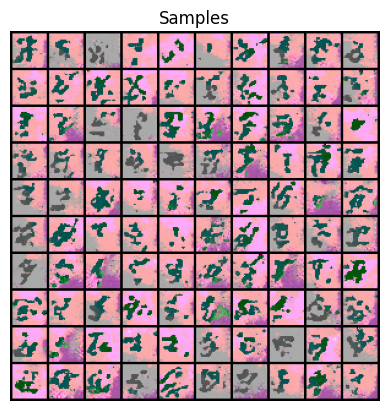

In [68]:
deepul_utils.show_samples(final_decoded_samples, None)

Quantizing...
Training...
Epoch 0, Train Loss: 6.346476912498474, Test Loss: 7.103042845916748
Epoch 1, Train Loss: 5.761426240205765, Test Loss: 5.944915274047852
Epoch 2, Train Loss: 5.447404712438583, Test Loss: 5.65620860824585
Epoch 3, Train Loss: 5.196414440870285, Test Loss: 5.433747198486328
Epoch 4, Train Loss: 5.019623130559921, Test Loss: 5.328487783813476
Epoch 5, Train Loss: 4.888928711414337, Test Loss: 5.255731917572022
Epoch 6, Train Loss: 4.762290567159653, Test Loss: 5.196793524932861
Epoch 7, Train Loss: 4.658186584711075, Test Loss: 5.176574243927002
Epoch 8, Train Loss: 4.555643707513809, Test Loss: 5.209963537597656
Epoch 9, Train Loss: 4.450961530208588, Test Loss: 5.190104838562012
Epoch 10, Train Loss: 4.346797913312912, Test Loss: 5.212798841094971
Epoch 11, Train Loss: 4.2494597136974335, Test Loss: 5.249762929534912
Epoch 12, Train Loss: 4.146313428878784, Test Loss: 5.266903424835205
Epoch 13, Train Loss: 4.054458171129227, Test Loss: 5.31319282836914
Epoch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


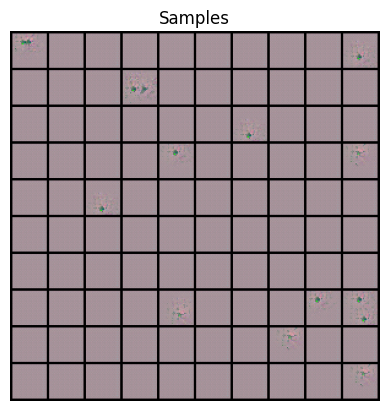

In [17]:
train_losses, test_losses, samples, model = q4b_save_results(
    1, q4_b, generate=True, save=False
)

In [ ]:
q4b_save_results(2, q4_b)

# Question 5: Causal Transformer: Text

Now lets consider text! You are probably already fimilar with autoregressive transformers for text, now more commonly known as Large Language Modesl (LLMs).
We will now implement a simplified version.

We will be detailing with a [small poetry dataset](https://huggingface.co/datasets/merve/poetry). See some of the data below.

In [3]:
data = visualize_q5_data()

Sample 1
I 
GLOOM! 
An October like November; 
August a hundred thousand hours, 
And all September, 
A hundred thousand, dragging sunlit days, 
And half October like a thousand years . . . 
And doom! 
That then was Antwerp. . . 
                              In the name of God, 
How could they do it? 
Those souls that usually dived 
Into the dirty caverns of mines; 
Who usually hived 
In whitened hovels; under ragged poplars; 
Who dragged muddy shovels, over the grassy mud, 
Lumbering to work over the greasy sods. . . 
Those men there, with the appearance of clods 
Were the bravest men that a usually listless priest of God 
Ever shrived. . . 
And it is not for us to make them an anthem. 
If we found words there would come no wind that would fan them 
To a tune that the trumpets might blow it, 
Shrill through the heaven that's ours or yet Allah's, 
Or the wide halls of any Valhallas. 
We can make no such anthem. So that all that is ours 
For inditing in sonnets, pantoums, elegiacs, or l

## Part (a) Modeling Text
Train a transformer on the poetry dataset.

Data Preprocessing:
* We will use a simple method to tokenize the data. We will convert each unique character into a token. (Current LLMs use more sophisticated tokenizers, most commonly, [byte-pair encoding](https://huggingface.co/learn/nlp-course/chapter6/5?fw=pt))
* Previously we have leveraged a **\<bos\>** as part of the model, just like iGPT. For text, we may not always sample a sequence that starts at the beginning. Instead, we will add the **\<bos\>** token to the beginning of every sequence in the dataset, and remove the **\<bos\>** token from the model.
* Another problem is that the model must know when to stop sampling. This is done by appending an **\<eos\>**, or end of sequence token at the end of every sequence in the dataset.
* We can now convert the sequence into subsequences of size context_length, for training!

We recommend the following hyperparameters:
* Sequence length: 128
* 5 epochs

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. Provide **5 unconditional samples** of **128 characters** showcasing the model text generation capabilities (text samples should stop after **\<eos\>**. Text after **\<eos\>** can be removed in post processing)

In [72]:
dir_path = deepul_utils.get_data_dir(1)
train_data, test_data = deepul_utils.load_text_data(
    os.path.join(dir_path, "poetry.pkl")
)

In [75]:
train_data[0]

'Let the bird of loudest lay\r\nOn the sole Arabian tree\r\nHerald sad and trumpet be,\r\nTo whose sound chaste wings obey.\r\n\r\nBut thou shrieking harbinger,\r\nFoul precurrer of the fiend,\r\nAugur of the fever\'s end,\r\nTo this troop come thou not near.\r\n\r\nFrom this session interdict\r\nEvery fowl of tyrant wing,\r\nSave the eagle, feather\'d king;\r\nKeep the obsequy so strict.\r\n\r\nLet the priest in surplice white,\r\nThat defunctive music can,\r\nBe the death-divining swan,\r\nLest the requiem lack his right.\r\n\r\nAnd thou treble-dated crow,\r\nThat thy sable gender mak\'st\r\nWith the breath thou giv\'st and tak\'st,\r\n\'Mongst our mourners shalt thou go.\r\n\r\nHere the anthem doth commence:\r\nLove and constancy is dead;\r\nPhoenix and the Turtle fled\r\nIn a mutual flame from hence.\r\n\r\nSo they lov\'d, as love in twain\r\nHad the essence but in one;\r\nTwo distincts, division none:\r\nNumber there in love was slain.\r\n\r\nHearts remote, yet not asunder;\r\nDis

In [95]:
from torch.utils.data import Dataset, DataLoader


class CharTokenizedTextDataset(Dataset):
    def __init__(self, data, context_length=128):
        self.bos_id = 0
        self.eos_id = 1
        self.token_to_id = {"<bos>": self.bos_id, "<eos>": self.eos_id}
        self.id_to_token = {self.bos_id: "<bos>", self.eos_id: "<eos>"}
        self.context_length = context_length
        self.encoded_data = []

        self.build_vocabulary(data)
        self.tokenize_data(data)

    @property
    def vocab_size(self) -> int:
        return len(self.token_to_id)

    def build_vocabulary(self, data):
        unique_chars = set(char for sequence in data for char in sequence)
        for i, char in enumerate(unique_chars, start=2):
            self.token_to_id[char] = i
            self.id_to_token[i] = char

    def tokenize_data(self, data):
        for sequence in data:
            tokenized_sequence = [self.token_to_id["<bos>"]]
            tokenized_sequence += [self.token_to_id[char] for char in sequence]
            tokenized_sequence += [self.token_to_id["<eos>"]]

            # Split into subsequences of the desired context_length
            for i in range(0, len(tokenized_sequence), self.context_length - 1):
                subsequence = tokenized_sequence[i : i + self.context_length]
                # If the subsequence is too short, pad it with <eos> tokens
                if len(subsequence) < self.context_length:
                    subsequence += [self.token_to_id["<eos>"]] * (
                        self.context_length - len(subsequence)
                    )
                self.encoded_data.append(subsequence)

    def decode(self, sequence, remove_eos=True):
        sequence = list(sequence)
        if remove_eos:
            if self.eos_id in sequence:
                eos_idx = sequence.index(self.eos_id)
                sequence = sequence[:eos_idx]
        tokens = [self.id_to_token[i] for i in sequence]
        return "".join(tokens)

    def __len__(self):
        return len(self.encoded_data)

    def __getitem__(self, idx):
        return torch.tensor(self.encoded_data[idx], dtype=torch.long)


def create_text_dataloader(train_data, batch_size=32, context_length=128, shuffle=True):
    dataset = CharTokenizedTextDataset(train_data, context_length=context_length)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [98]:
def q5_a(train_text, test_text, generate=True):
    """
    train_text: list[str] Train text sequences.
    test_text: list[str] Test text sequences.

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a list of 5 (str), 5 generated samples from the model.
    """
    batch_size = 64
    context_length = 128
    epochs = 30
    lr = 1e-3
    num_layers = 4
    d_model = 128
    num_heads = 4
    dropout = 0.0
    verbose = True

    np.random.seed(0)
    torch.manual_seed(0)

    # Set to None to use the full dataset
    max_num_train_examples = None
    if max_num_train_examples is not None:
        train_text = train_text[:max_num_train_examples]

    # Make dataloaders
    train_dataset = CharTokenizedTextDataset(train_text, context_length=context_length)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = CharTokenizedTextDataset(test_text, context_length=context_length)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    vocab_size = train_dataset.vocab_size

    model = Transformer(
        context_length, vocab_size, num_layers, d_model, num_heads, dropout
    ).cuda()

    if verbose:
        print("Training...")
    train_losses, test_losses = train_transformer(
        model, train_loader, test_loader, epochs, lr, verbose=verbose
    )

    if verbose:
        print("Sampling...")

    if generate:
        num_samples = 5
        samples, _ = sample(
            model,
            num_samples,
            # Subtract 1 to account for the <bos> token
            context_length - 1,
            "cuda",
            train_dataset.bos_id,
            use_cache=True,
        )
        text_samples = [
            train_dataset.decode(sequence, remove_eos=True) for sequence in samples
        ]
    else:
        text_samples = None

    return train_losses, test_losses, text_samples, model

### Results

Once you've implemented `q5_a`, execute the cells below to visualize and save your results



Training...
Epoch 0, Train Loss: 2.4483389168569487, Test Loss: 4.55928069069272
Epoch 1, Train Loss: 2.206661773054567, Test Loss: 6.1984969320751375
Epoch 2, Train Loss: 2.0414803420027643, Test Loss: 6.37247253599621
Epoch 3, Train Loss: 1.8989252325606674, Test Loss: 5.891992182958694
Epoch 4, Train Loss: 1.786167660804644, Test Loss: 6.290943781534831
Epoch 5, Train Loss: 1.7040176179311046, Test Loss: 6.416987373715355
Epoch 6, Train Loss: 1.6364708501998693, Test Loss: 6.421779019492013
Epoch 7, Train Loss: 1.5820176895350626, Test Loss: 6.778527237120128
Epoch 8, Train Loss: 1.5311367642389584, Test Loss: 6.501777648925781
Epoch 9, Train Loss: 1.4865188516982615, Test Loss: 6.422176610855829
Epoch 10, Train Loss: 1.4441236633144012, Test Loss: 6.622794219425747
Epoch 11, Train Loss: 1.403287304590826, Test Loss: 6.844323249090285
Epoch 12, Train Loss: 1.3623656752991349, Test Loss: 6.940667856307257
Epoch 13, Train Loss: 1.3219001521802929, Test Loss: 6.889786107199533
Epoch 14

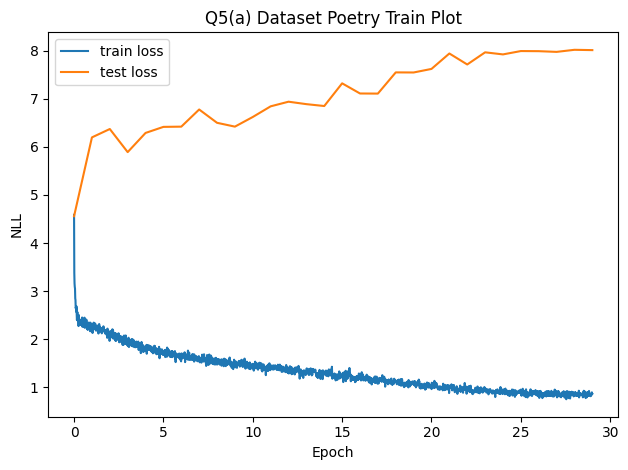

Sample 1
Wyat now it now the safts that knows,
That pity is true, and none hour shall dell,
That she all the wand?
O treasure, as tho

Sample 2
Knoon Sleep
The risesurress, who spooted new the perflomisght they pluce plide pleas:
Fayre soft what uncloth againe suffy.

Sample 3
Her lord, and all  things guiding, so thal that lay.
Let thereto thou threadst thou not sing,
Or is proud in her him, wait ti

Sample 4
Whou, should have hands have next cantered ance?
         There candles-forever, and will I never mantion in my breast.
On th

Sample 5
"Forme:calo, and come a man'st,
When I had you be not far:
But he turned blitten,
Through hollow than my horse
Great with h



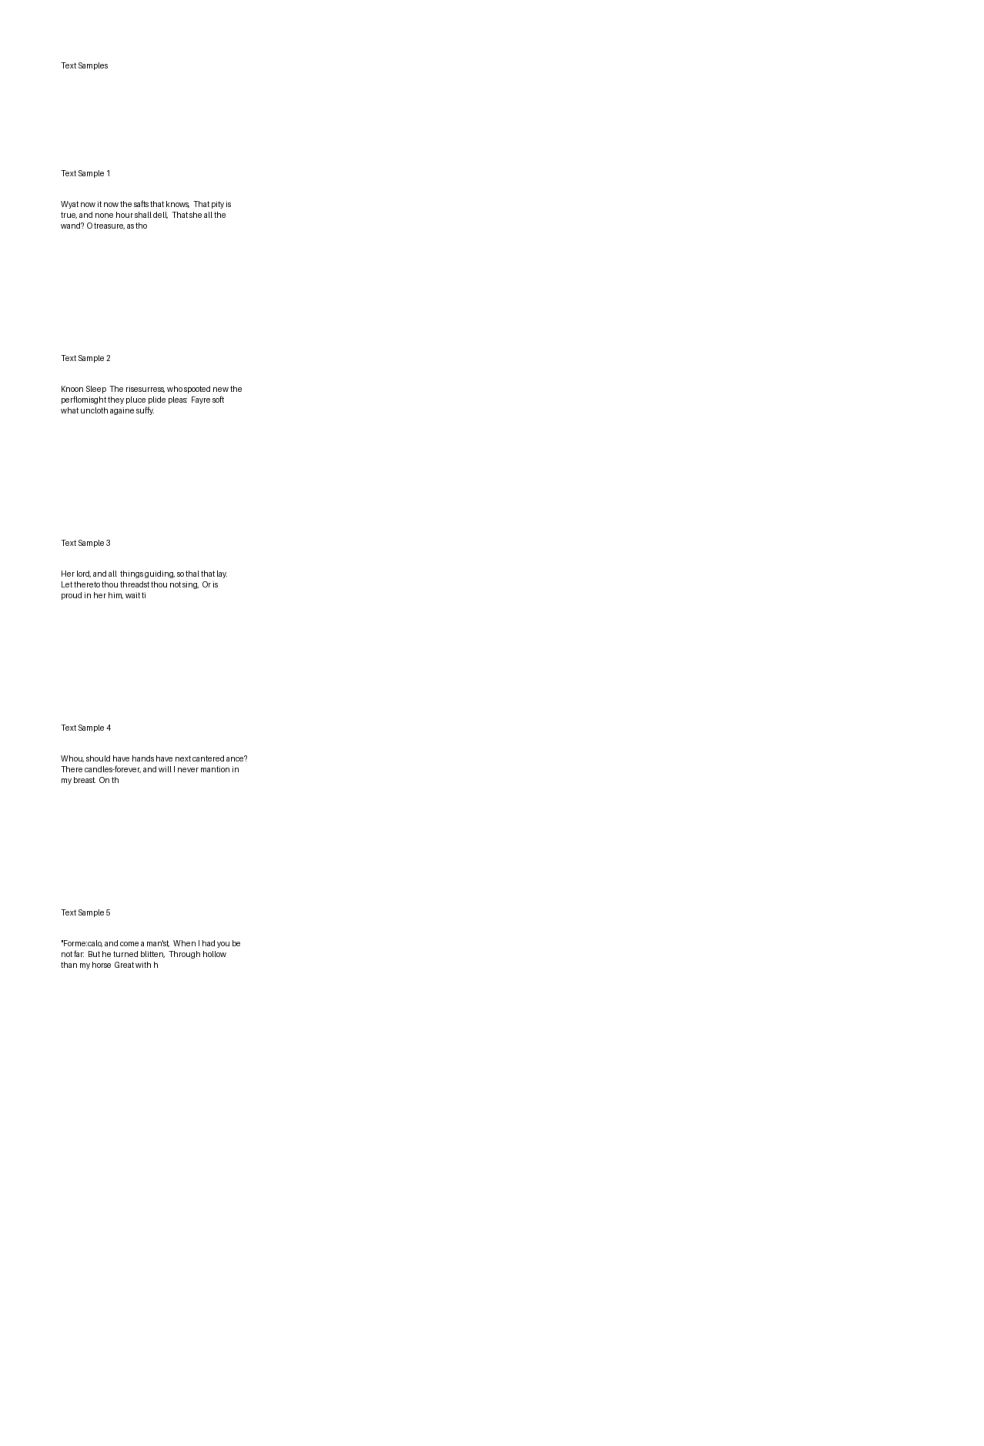

In [97]:
train_losses, test_losses, text_samples, model = q5a_save_results(
    q5_a, generate=True, save=True
)

In [19]:
dir_path = deepul_utils.get_data_dir(1)
train_text, test_text = deepul_utils.load_text_data(
    os.path.join(dir_path, "poetry.pkl")
)

In [20]:
batch_size = 64
context_length = 128
epochs = 5
lr = 1e-3
num_layers = 4
d_model = 128
num_heads = 4
dropout = 0.0
verbose = True

np.random.seed(0)
torch.manual_seed(0)

# Set to None to use the full dataset
max_num_train_examples = None
if max_num_train_examples is not None:
    train_text = train_text[:max_num_train_examples]

# Make dataloaders
train_dataset = CharTokenizedTextDataset(train_text, context_length=context_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = CharTokenizedTextDataset(test_text, context_length=context_length)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

vocab_size = train_dataset.vocab_size

In [42]:
seq_len = 128
num_samples = 5
bos_token = 0
device = "cuda"
prevent_sampling_bos = True
use_cache = True

model.eval()
if use_cache:
    model.clear_cache()

# [num_samples, seq_len]
samples = torch.full(
    (num_samples, 1), fill_value=bos_token, dtype=torch.long, device=device
)  # Initialize with <bos> token

time_list = []

for i in range(seq_len - 1):
    start = time.time()
    # Shape: [num_samples, vocab_size, seq_len]
    logits = model(samples, use_cache=use_cache)
    time_delta = time.time() - start
    if i > 0:
        time_list.append(time_delta)
    if prevent_sampling_bos:
        # Prevent sampling the <bos> token again
        logits[:, bos_token] = -1e10
    # Shape: [num_samples, vocab_size, seq_len]
    probs = F.softmax(logits, dim=1)
    # Shape: [num_samples, seq_len] (seq_len = 1 if use_cache=True)
    next_token = torch.multinomial(probs[:, :, -1], 1)
    samples = torch.cat([samples, next_token], dim=1)

# Remove the BOS token.
samples = samples[:, 1:]
samples = np.asarray(samples.cpu())

In [43]:
text_samples = [train_dataset.decode(sequence) for sequence in samples]

In [45]:
text_samples[0]

'T And  do 19&e I on by hin wits alil ad hight i0.\r\nGs And Ogin at Dell al (XAno shern cince slawng\r\nAnd ros! mer be.\r\nYome fong'

In [12]:
logits.shape

torch.Size([5, 85, 1])

# Question 6: Causal Transformer: Multimodal

So far, we have been dealing only with autoregressive generation of a single modality. Now we will train a model that operates on multiple modalities!

We will use the text labeled colored MNIST dataset, which has a text description of the MNIST image. Run the cell below to visualize the data along with the text annotation. This is the Colored MNIST v2 dataset, which also comes with these text labels.

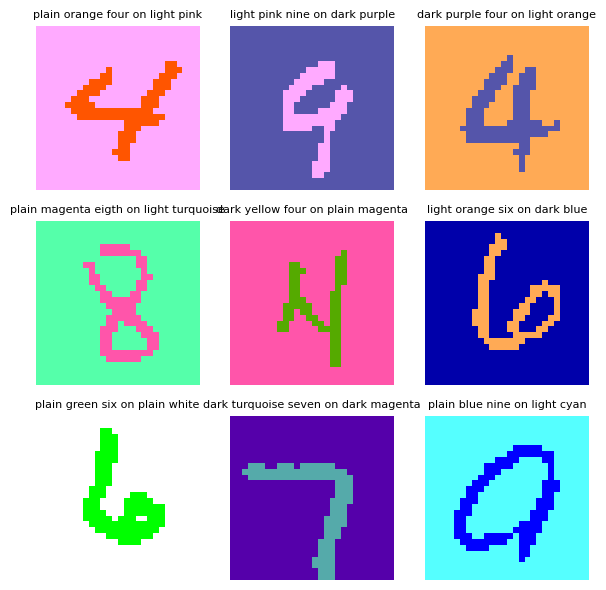

In [3]:
visualize_q6_data()

## Part (a) Multimodal Text and Image Generation
Implement and train an autoregressive (AR) model capable of handling both text and image data. The model should be designed to process sequences composed of concatenated text and image tokens in both orders (text followed by images and images followed by text). Additionally, the model should be capable of generating unconditional text and image samples.

Data Preprocessing:
* Text Tokens: Map each unique word in the text data to a unique token. (Note that all text descriptions contain the exact same amount of words. This simplifies text processing, as you won't have to deal with sequences of different lengths as in Question 5)
* Image Tokens: Quantize the image data into tokens using the VQVAE tokenizer from Problem 4.
* In this problem, we have 2 modalities. Introduce an **\<end of text\>** token and an **\<end of image\>** token. After seeing such a token, the model should switch to sampling the next modality.
* Formulate batches as sequences of concat([**\<end of image\>**, text_tokens, **\<end of text\>**, image_tokens]) and concat([**\<end of text\>**, image_tokens, **\<end of image\>**, text_tokens]). With a 50/50 split between each ordering.

Inference:
* During inference, we cannot mix modality tokens. During sampling we can restrict the logits to only be within the relevant modality.
* After **\<end of image\>**, only allow the model to sample text tokens (including **\<end of text\>**)
* After **\<end of text\>**, only allow the model to sample image tokens (including **\<end of image\>**)
* At the very start (conditioned on the **\<bos\>** token, only allow the model to sample one of (**\<end of image\>** or **\<end of text\>**))
* As the model may not always correctly sample the **\<end of image\>** token before the image ends, you may add a rule to force the model to always sample the correct number of image tokens (49 tokens).

You can use the same hyperparameters as in 4(b) (but of course, feel free to tune your model to achieve better performance)

**You will provide these deliverables**

1. Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2. Report the final test set performance of your final model
3. 9 conditional samples based on provided text.
4. 9 conditional samples based on provided images.
5. 9 unconditional samples showcasing the model's capability in generating standalone text and images.

In [3]:
from torch.utils.data import Dataset, DataLoader
from collections import Counter


class MultimodalDataset(data.Dataset):
    def __init__(
        self, text_data, image_data, vqvae, quantized_image_shape, verbose=False
    ):
        self.bos_token = 0
        self.bos_str = "<bos>"
        self.end_of_text_token = 1
        self.end_of_text_str = "<end of text>"
        self.end_of_image_token = 2
        self.end_of_image_str = "<end of image>"
        self.num_special_tokens = 3

        self.text_data = text_data
        self.image_data = image_data
        self.vqvae = vqvae

        self.quantized_image_shape = quantized_image_shape
        self.image_sequence_length = np.prod(quantized_image_shape)

        self.text_sequence_length = len(self.text_data[0].split())
        self.compute_sequence_length()

        # Build vocabulary for text
        if verbose:
            print("Building text vocabulary...")
        self.build_text_vocabulary()
        # Adjust image token IDs to not overlap with special and text tokens
        self.image_token_offset = 2 + len(self.token_to_id) + 1

        # Token ranges (start, end (exclusive))
        self.text_token_range = (
            self.num_special_tokens,
            self.num_special_tokens + self.text_vocab_size,
        )
        self.image_token_range = (
            self.text_token_range[1],
            self.text_token_range[1] + self.image_vocab_size,
        )

        # Preprocess data
        if verbose:
            print("Preprocessing data...")
        self.encoded_data = self.preprocess_data()

    @property
    def text_vocab_size(self) -> int:
        return len(self.token_to_id)

    @property
    def image_vocab_size(self) -> int:
        return self.vqvae.n_embeddings

    @property
    def vocab_size(self) -> int:
        return self.text_vocab_size + self.image_vocab_size + self.num_special_tokens

    def compute_sequence_length(self):
        self.sequence_length = (
            self.num_special_tokens
            + self.text_sequence_length
            + self.image_sequence_length
        )

    def build_text_vocabulary(self):
        word_counts = Counter(
            word for sentence in self.text_data for word in sentence.split()
        )
        self.token_to_id = {}
        for i, word in enumerate(word_counts.keys(), start=self.num_special_tokens):
            self.token_to_id[word] = i
        self.id_to_token = {id: word for word, id in self.token_to_id.items()}

    def encode_image(self, image):
        quantized_image = self.vqvae.quantize(image[np.newaxis, ...]).flatten()
        quantized_image += self.image_token_offset
        return quantized_image

    def condition_on_image(self, image):
        image_tokens = self.encode_image(image)
        return (
            [self.bos_token, self.end_of_text_token]
            + list(image_tokens)
            + [self.end_of_image_token]
        )

    def encode_text(self, text):
        return [self.token_to_id[word] for word in text.split()]

    def condition_on_text(self, text):
        return (
            [self.bos_token, self.end_of_image_token]
            + self.encode_text(text)
            + [self.end_of_text_token]
        )

    def preprocess_data(self):
        encoded_data = []
        for text, image in zip(self.text_data, self.image_data):
            # Tokenize text
            text_tokens = self.encode_text(text)
            # Quantize image and adjust tokens
            image_tokens = self.encode_image(image)

            # Combine text and image sequences
            sequence_ti = (
                [self.bos_token, self.end_of_image_token]
                + text_tokens
                + [self.end_of_text_token]
                + list(image_tokens)
            )
            sequence_it = (
                [self.bos_token, self.end_of_text_token]
                + list(image_tokens)
                + [self.end_of_image_token]
                + text_tokens
            )
            encoded_data.append(sequence_ti)
            encoded_data.append(sequence_it)

        return encoded_data

    def decode(self, samples):
        decoded_samples = []
        for sample in samples:
            if sample[0] == self.end_of_text_token:
                # First modality is image
                quantized_image = sample[1 : 1 + self.image_sequence_length]
                text = sample[2 + self.image_sequence_length :]
            elif sample[0] == self.end_of_image_token:
                # First modality is text
                text = sample[1 : 1 + self.text_sequence_length]
                quantized_image = sample[2 + self.text_sequence_length :]
            else:
                raise ValueError(f"Invalid first token: {samples[0]}")
            quantized_image = quantized_image.reshape(self.quantized_image_shape)[
                np.newaxis, ...
            ]
            quantized_image = quantized_image - self.image_token_offset
            # Decode the image and remove the batch dimension
            image = self.vqvae.decode(quantized_image)[0]
            text = " ".join(self.id_to_token[t] for t in text)
            decoded_samples.append((image, text))

        return decoded_samples

    def __len__(self):
        return len(self.encoded_data)

    def __getitem__(self, idx):
        sequence = self.encoded_data[idx]
        return torch.tensor(sequence, dtype=torch.long)

In [4]:
def multimodal_sample(
    model,
    train_dataset: MultimodalDataset,
    num_samples,
    seq_len,
    device,
    bos_token,
    end_of_text_token,
    end_of_image_token,
    text_token_range,
    image_token_range,
    text_sequence_length,
    image_sequence_length,
    image_test_prompt=None,
    text_test_prompt=None,
    use_cache=True,
):
    if image_test_prompt is not None and text_test_prompt is not None:
        raise ValueError(
            "Only one of image_test_prompt and text_test_prompt can be set."
        )

    model.eval()
    if use_cache:
        model.clear_cache()

    if image_test_prompt is not None:
        samples = []
        for image in image_test_prompt:
            samples.append(train_dataset.condition_on_image(image))
        samples = torch.tensor(samples, dtype=torch.long, device=device)
        # Initialize modality for each sample, True for text, False for image.
        current_modality = torch.full(
            (num_samples,), True, dtype=torch.bool, device=device
        )
    elif text_test_prompt is not None:
        samples = []
        for text in text_test_prompt:
            samples.append(train_dataset.condition_on_text(text))
        samples = torch.tensor(samples, dtype=torch.long, device=device)
        # Initialize modality for each sample, True for text, False for image.
        current_modality = torch.full(
            (num_samples,), False, dtype=torch.bool, device=device
        )
    else:
        # Initialize samples with <bos> token
        samples = torch.full(
            (num_samples, 1), fill_value=bos_token, dtype=torch.long, device=device
        )
        # Initialize modality for each sample, True for text, False for image.
        # Set to True arbitrarily for step=0.
        current_modality = torch.full(
            (num_samples,), True, dtype=torch.bool, device=device
        )

    # Tracks the number of tokens sampled for the current modality
    tokens_sampled_per_modality = torch.zeros(
        num_samples, dtype=torch.long, device=device
    )

    time_list = []

    # Step start number. 0 for unconditioned samples, greater than 0 for
    # conditioned samples.
    start_step = samples.shape[1] - 1

    for step in range(start_step, seq_len):
        start = time.time()
        # Get logits for the last token only
        # [num_samples, vocab_size, seq_len]
        logits_seq = model(samples, use_cache=use_cache)
        time_delta = time.time() - start
        if step > 0:
            time_list.append(time_delta)
        # [num_samples, vocab_size]
        logits = logits_seq[:, :, -1]

        # Prevent sampling <bos> token again
        logits[:, bos_token] = -1e10

        # Mask logits based on the current modality for each sample
        mask = torch.full_like(logits, fill_value=-1e10)
        for idx, is_text in enumerate(current_modality):
            if step == 0:  # At the start, only allow <end of image> or <end of text>
                mask[idx, [end_of_text_token, end_of_image_token]] = logits[
                    idx, [end_of_text_token, end_of_image_token]
                ]
            elif is_text:
                if tokens_sampled_per_modality[idx] == text_sequence_length:
                    # Force <end of text> token if text sequence length reached
                    mask[idx, end_of_text_token] = 0
                else:
                    # Otherwise, allow only text tokens and <end of text>
                    mask[idx, text_token_range[0] : text_token_range[1]] = logits[
                        idx, text_token_range[0] : text_token_range[1]
                    ]
                    # mask[idx, end_of_text_token] = logits[idx, end_of_text_token]
            else:  # Allow only image tokens and <end of image>
                if tokens_sampled_per_modality[idx] == image_sequence_length:
                    # Force <end of image> token if image sequence length reached
                    mask[idx, end_of_image_token] = 0
                else:
                    # Otherwise, allow only image tokens and <end of image>
                    mask[idx, image_token_range[0] : image_token_range[1]] = logits[
                        idx, image_token_range[0] : image_token_range[1]
                    ]
                    # mask[idx, end_of_image_token] = logits[idx, end_of_image_token]

        logits = mask

        # Sample next token
        probs = F.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, 1)
        samples = torch.cat([samples, next_token], dim=1)

        # Update counters and modality
        for idx, token in enumerate(next_token.squeeze(-1)):
            if current_modality[idx]:  # If currently sampling text
                if token == end_of_text_token:
                    current_modality[idx] = False  # Switch to image
                    tokens_sampled_per_modality[idx] = 0  # Reset counter
                elif token != end_of_image_token:
                    tokens_sampled_per_modality[idx] += 1
            else:  # If currently sampling image
                if token == end_of_image_token:
                    current_modality[idx] = True  # Switch to text
                    tokens_sampled_per_modality[idx] = 0  # Reset counter
                elif token != end_of_text_token:
                    tokens_sampled_per_modality[idx] += 1

    # Remove the BOS token from the start of samples
    samples = samples[:, 1:]

    return np.asarray(samples.cpu()), time_list

In [14]:
max_num_examples = 16

data_dir = deepul_utils.get_data_dir(1)
train_data, test_data, train_labels, test_labels = deepul_utils.load_colored_mnist_text(
    os.path.join(data_dir, "colored_mnist_with_text.pkl")
)
vqvae = hw1_helper.load_pretrain_vqvae("colored_mnist_2")
img_shape = (28, 28, 3)

max_num_examples = 16
if max_num_examples is not None:
    train_data = train_data[:max_num_examples]
    train_labels = train_labels[:max_num_examples]

# Assuming you have text_data, image_data, and a trained vqvae instance
# Example usage:
train_dataset = MultimodalDataset(
    train_labels, train_data, vqvae, quantized_image_shape=(7, 7), verbose=True
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

Building text vocabulary...
Preprocessing data...


In [21]:
multimodal_batch = next(iter(train_loader))

In [23]:
multimodal_batch[0]

tensor([   0,    2,    3,    4,    5,    6,    7,    8,    1,  318,  105,  671,
         105,  937,  937,  318,  432,  994,  295,  666,  455,  457,  432,  937,
        1023,  646,  534,  877,  748,  432,  105,  926,  913,  304,  918,  318,
         451,  105,  671,  994,  449,  462,  451,  451,  366,  481,  889,  934,
         147,  432,  318,  147,  724,  360,  366,  432,  318,  451])

In [29]:
multimodal_ex = multimodal_batch[0]
if multimodal_ex[1] == train_dataset.end_of_image_token:
    text_tokens = multimodal_ex[2 : 2 + train_dataset.text_sequence_length]
    image_tokens = multimodal_ex[3 + train_dataset.text_sequence_length :]
elif multimodal_ex[1] == train_dataset.end_of_text_token:
    image_tokens = multimodal_ex[2: 2 + train_dataset.image_sequence_length]
    text_tokens = multimodal_ex[3 + train_dataset.image_sequence_length:]

In [34]:
train_data.shape

(16, 28, 28, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


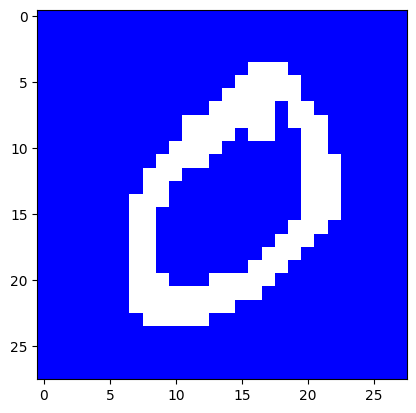

In [40]:
plt.imshow(train_data[1] / 3 * 255)

In [44]:
train_labels[:num_samples]

['light green five on dark magenta', 'dark green zero on plain blue']

In [42]:
use_cache = True
num_samples = 2
# Subtract 1 to account for the <bos> token
seq_len = train_dataset.sequence_length - 1
device = "cuda"
bos_token = train_dataset.bos_token
end_of_text_token = train_dataset.end_of_text_token
end_of_image_token = train_dataset.end_of_image_token

samples, _ = multimodal_sample(
    model,
    train_dataset,
    num_samples,
    seq_len,
    device,
    bos_token,
    end_of_text_token,
    end_of_image_token,
    train_dataset.text_token_range,
    train_dataset.image_token_range,
    train_dataset.text_sequence_length,
    train_dataset.image_sequence_length,
    # image_test_prompt=train_data[:num_samples],
    text_test_prompt=train_labels[:num_samples],
    use_cache=True,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


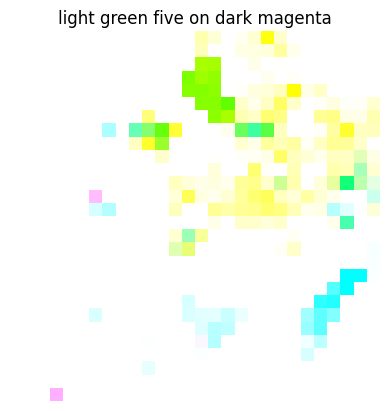

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


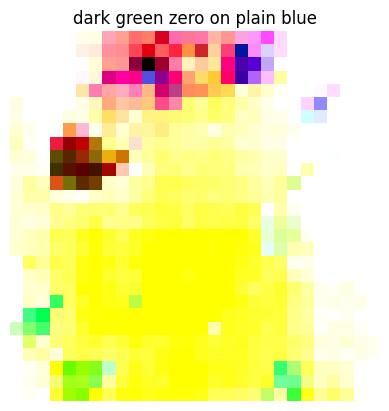

In [43]:
multimodal_samples = train_dataset.decode(samples)
for image, text in multimodal_samples:
    plt.figure()
    plt.imshow(image)
    plt.title(text)
    plt.axis("off")
    plt.show()

In [45]:
def q6_a(
    train_data,
    test_data,
    image_shape,
    train_text,
    test_text,
    image_test_prompt,
    text_test_prompt,
    vqvae,
    generate=True,
):
    """
    train_data: A (n_train, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    test_data: A (n_test, H, W, C) uint8 numpy array of color images with values in {0, 1, 2, 3}
    image_shape: tuple (H, W, C) The shape of the images in the dataset, indicating height, width, and number of color channels.
    train_text: list[str] Text data associated with each training image.
    test_text: list[str] Text data associated with each test image.
    image_test_prompt: (9, H, W, C) Image data used for generating conditional text samples during testing.
    text_test_prompt: list of 9 strings Text prompts used for generating conditional image samples during testing.
    vqvae: a vqvae model, trained on the relevant dataset

    Returns
    - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
    - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
    - a list of 9 (image, text), corresponding to the image conditioned samples
    - a list of 9 (image, text), corresponding to the text conditions samples
    - a list of 9 (image, text), corresponding to unconditional samples
    """
    batch_size = 64
    epochs = 10
    lr = 1e-3
    num_layers = 4
    d_model = 128
    num_heads = 4
    dropout = 0.0
    verbose = True

    np.random.seed(0)
    torch.manual_seed(0)

    # Set to None to use the full dataset
    max_num_examples = 100
    if max_num_examples is not None:
        train_data = train_data[:max_num_examples]
        train_text = train_text[:max_num_examples]
        test_data = test_data[:max_num_examples]
        test_text = test_text[:max_num_examples]

    quantized_image_shape = (7, 7)
    train_dataset = MultimodalDataset(
        train_text,
        train_data,
        vqvae,
        quantized_image_shape=quantized_image_shape,
        verbose=True,
    )
    train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = MultimodalDataset(
        test_text,
        test_data,
        vqvae,
        quantized_image_shape=quantized_image_shape,
        verbose=True,
    )
    test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    vocab_size = train_dataset.vocab_size

    seq_len = train_dataset.sequence_length
    model = Transformer(
        seq_len, vocab_size, num_layers, d_model, num_heads, dropout
    ).cuda()

    if verbose:
        print("Training...")
    train_losses, test_losses = train_transformer(
        model, train_loader, test_loader, epochs, lr, verbose=verbose
    )

    if generate:
        if verbose:
            print("Sampling...")
        num_samples = 9
        samples_unconditioned, _ = multimodal_sample(
            model,
            train_dataset,
            num_samples,
            # Subtract 1 to account for the <bos> token
            seq_len - 1,
            "cuda",
            train_dataset.bos_token,
            train_dataset.end_of_text_token,
            train_dataset.end_of_image_token,
            train_dataset.text_token_range,
            train_dataset.image_token_range,
            train_dataset.text_sequence_length,
            train_dataset.image_sequence_length,
            use_cache=True,
        )
        samples_unconditioned = train_dataset.decode(samples_unconditioned)

        samples_text_conditioned, _ = multimodal_sample(
            model,
            train_dataset,
            num_samples,
            # Subtract 1 to account for the <bos> token
            seq_len - 1,
            "cuda",
            train_dataset.bos_token,
            train_dataset.end_of_text_token,
            train_dataset.end_of_image_token,
            train_dataset.text_token_range,
            train_dataset.image_token_range,
            train_dataset.text_sequence_length,
            train_dataset.image_sequence_length,
            text_test_prompt=text_test_prompt,
            use_cache=True,
        )
        samples_text_conditioned = train_dataset.decode(samples_text_conditioned)

        samples_image_conditioned, _ = multimodal_sample(
            model,
            train_dataset,
            num_samples,
            # Subtract 1 to account for the <bos> token
            seq_len - 1,
            "cuda",
            train_dataset.bos_token,
            train_dataset.end_of_text_token,
            train_dataset.end_of_image_token,
            train_dataset.text_token_range,
            train_dataset.image_token_range,
            train_dataset.text_sequence_length,
            train_dataset.image_sequence_length,
            image_test_prompt=image_test_prompt,
            use_cache=True,
        )
        samples_image_conditioned = train_dataset.decode(samples_image_conditioned)
    else:
        samples_image_conditioned = samples_text_conditioned = samples_unconditioned = (
            None
        )

    return (
        train_losses,
        test_losses,
        samples_image_conditioned,
        samples_text_conditioned,
        samples_unconditioned,
        model,
    )

### Results

Once you've implemented `q6_a`, execute the cells below to visualize and save your results



In [9]:
from importlib import reload

del q6a_save_results
reload(hw1_helper)
from deepul.hw1_helper import q6a_save_results

In [46]:
(
    train_losses,
    test_losses,
    samples_image_conditioned,
    samples_text_conditioned,
    samples_unconditioned,
    model,
) = q6a_save_results(q6_a, generate=True, save=False)

Building text vocabulary...
Preprocessing data...


In [35]:
model

NameError: name 'model' is not defined